# Wstęp do Uczenia Maszynowego Projekt 1

#### Jędrzej Sokołowski, Filip Szympliński
#### 23 kwietnia 2022

## Wstęp

Poniższa praca jest raportem z pracy nad projektem nr 1 z przedmiotu Wstęp do Uczenia maszynowego. Celem projektu było opracowanie modelu przewidującego rezultat rozgrywek szachowych w sytuacjach gdy na szachownicy zostały jedynie trzy figury, biała wieża, biały król oraz czarny król. Zadaniem modelu jest podanie liczby w zakresie od -1 do 16 gdzie -1 odpowiada remisowi (albo okolicznościom bez mata w 16 ruchach) a jakakolwiek inna liczba ilości ruchów do zwycięstwa białych figur.

### Wczytanie potrzebnych pakietów oraz danych

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ustawia domyślną wielkość wykresów
plt.rcParams['figure.figsize'] = (12,12)
# to samo tylko dla tekstu
plt.rcParams['font.size'] = 16
# ustawia wielkość tekstów dla wykresów seaborn zależną od wielkości wykresu
sns.set_context('paper', font_scale=1.4)

In [3]:
data = pd.read_csv("chess_king_rook_dataset.csv", sep=",")

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop("result", axis=1)
y = data["result"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=420, test_size=0.2)

data = pd.concat([X_train_val, y_train_val], axis = 1)

# X_test.to_csv("X_test.csv")
# y_test.to_csv("y_test.csv")

In [5]:
data = data.reset_index()
data = data.drop("index", axis=1)

In [6]:
data1 = data.copy()

# EDA oraz preprocessing

## EDA - część 1.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22444 entries, 0 to 22443
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   white_king_file  22444 non-null  object
 1   white_king_rank  22444 non-null  int64 
 2   white_rook_file  22444 non-null  object
 3   white_rook_rank  22444 non-null  int64 
 4   black_king_file  22444 non-null  object
 5   black_king_rank  22444 non-null  int64 
 6   result           22444 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.2+ MB


Nie ma braków danych

### Opisy zmiennych

`white_king_file`: Column location on the chess board of the white king

`white_king_rank`: Row location on the chess board of the white king

`white_rook_file`: Column location on the chess board of the white rook

`white_rook_rank`: Row location on the chess board of the white rook

`black_king_file`: Column location on the chess board of the black king

`black_king_rank`: Row location on the chess board of the black king

`result`: Predictor Class. optimal depth-of-win for White in 0 to 16 moves, otherwise drawn Values: {draw, zero, one, two, ..., sixteen}

### Rozkłady zmiennych położenia

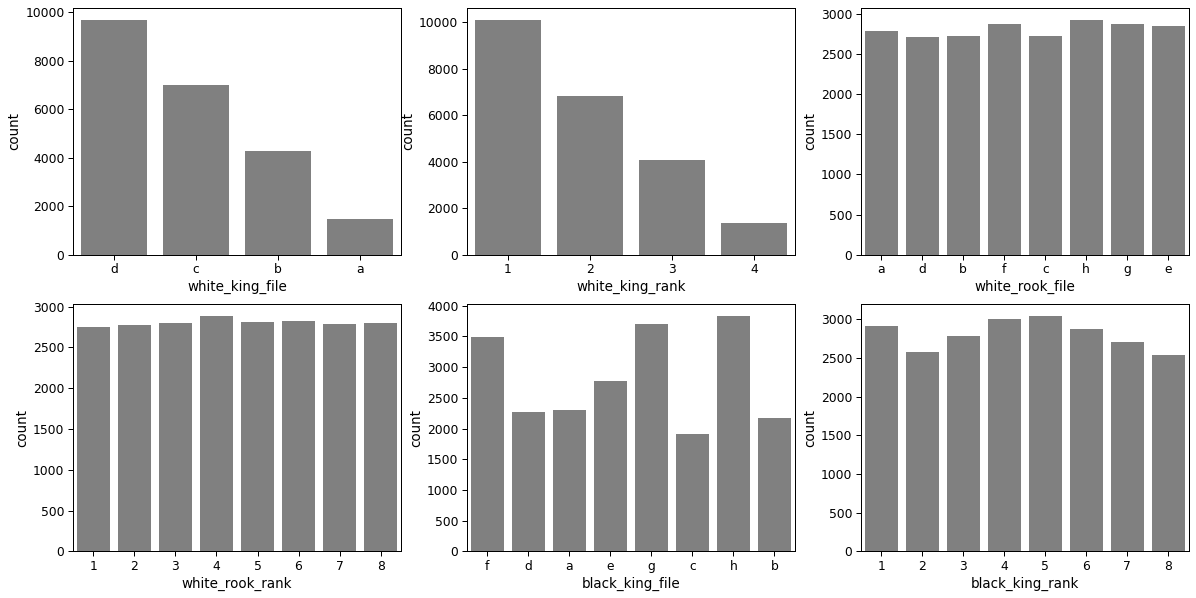

In [8]:
fig, axes = plt.subplots(2,3, figsize = (20, 10))

for col, ax in zip(data.loc[:,~data.columns.isin(["result"])].columns, axes.flatten()):
    sns.countplot(x=col, data=data, ax=ax, color='gray')

Widać tutaj, że zmienne white_rook_rank, white_rook_file oarz black_king_rank mają rozkład zbliżony do jednostajnego. O rozkładach reszty zmiennych nie można wyciągną żadnych dalekoidących wniosków.

### Rozkład zmiennej celu (result)

In [9]:
my_dict = {'draw': -1, 'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6,
        'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10, 'eleven': 11, 'twelve': 12, 'thirteen': 13, 
        'fourteen': 14, 'fifteen': 15, 'sixteen': 16}

for key in my_dict.keys():
    data.loc[data["result"] == key, "result"] = my_dict[key] + 1

data['result'] = data['result'].astype('int')

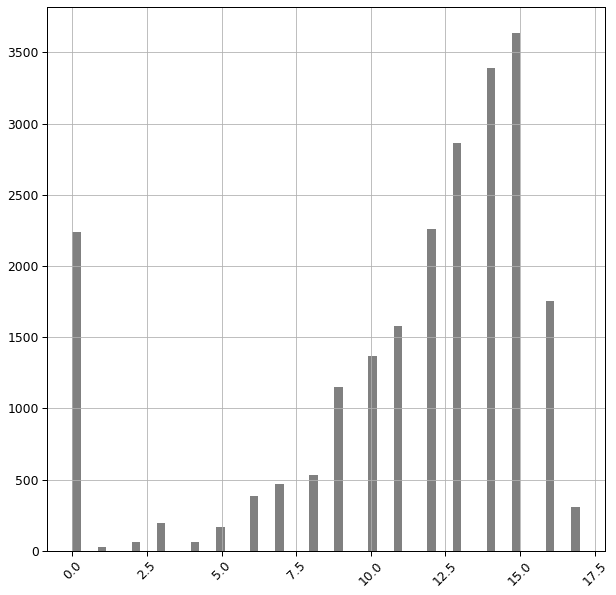

In [10]:
plt.rcParams['figure.figsize'] = (10,10)
data["result"].hist(bins = 60, color='gray')
plt.xticks(rotation=45)
plt.show()

In [11]:
print(f"Średnia: {data['result'].mean()}")
print(f"Mediana {data['result'].median()}")
print(f"Moda: {data['result'].mode()}")

Średnia: 11.260114061664588
Mediana 13.0
Moda: 0    15
Name: result, dtype: int32


Z powyższego histogramu widać, że pomijając wartość draw, która w pewnym sensie należy do osobnej kategorii, zmienna result ma rozkład mocno skośny w lewo (negative skew).

Jak widać z powyższych wartości i ich relacji (średnia < mediana < moda) mamy faktycznie do czynienia z rozkładem lewoskośnym.

### Rozkłady zmiennych położenia względem zmiennej celu

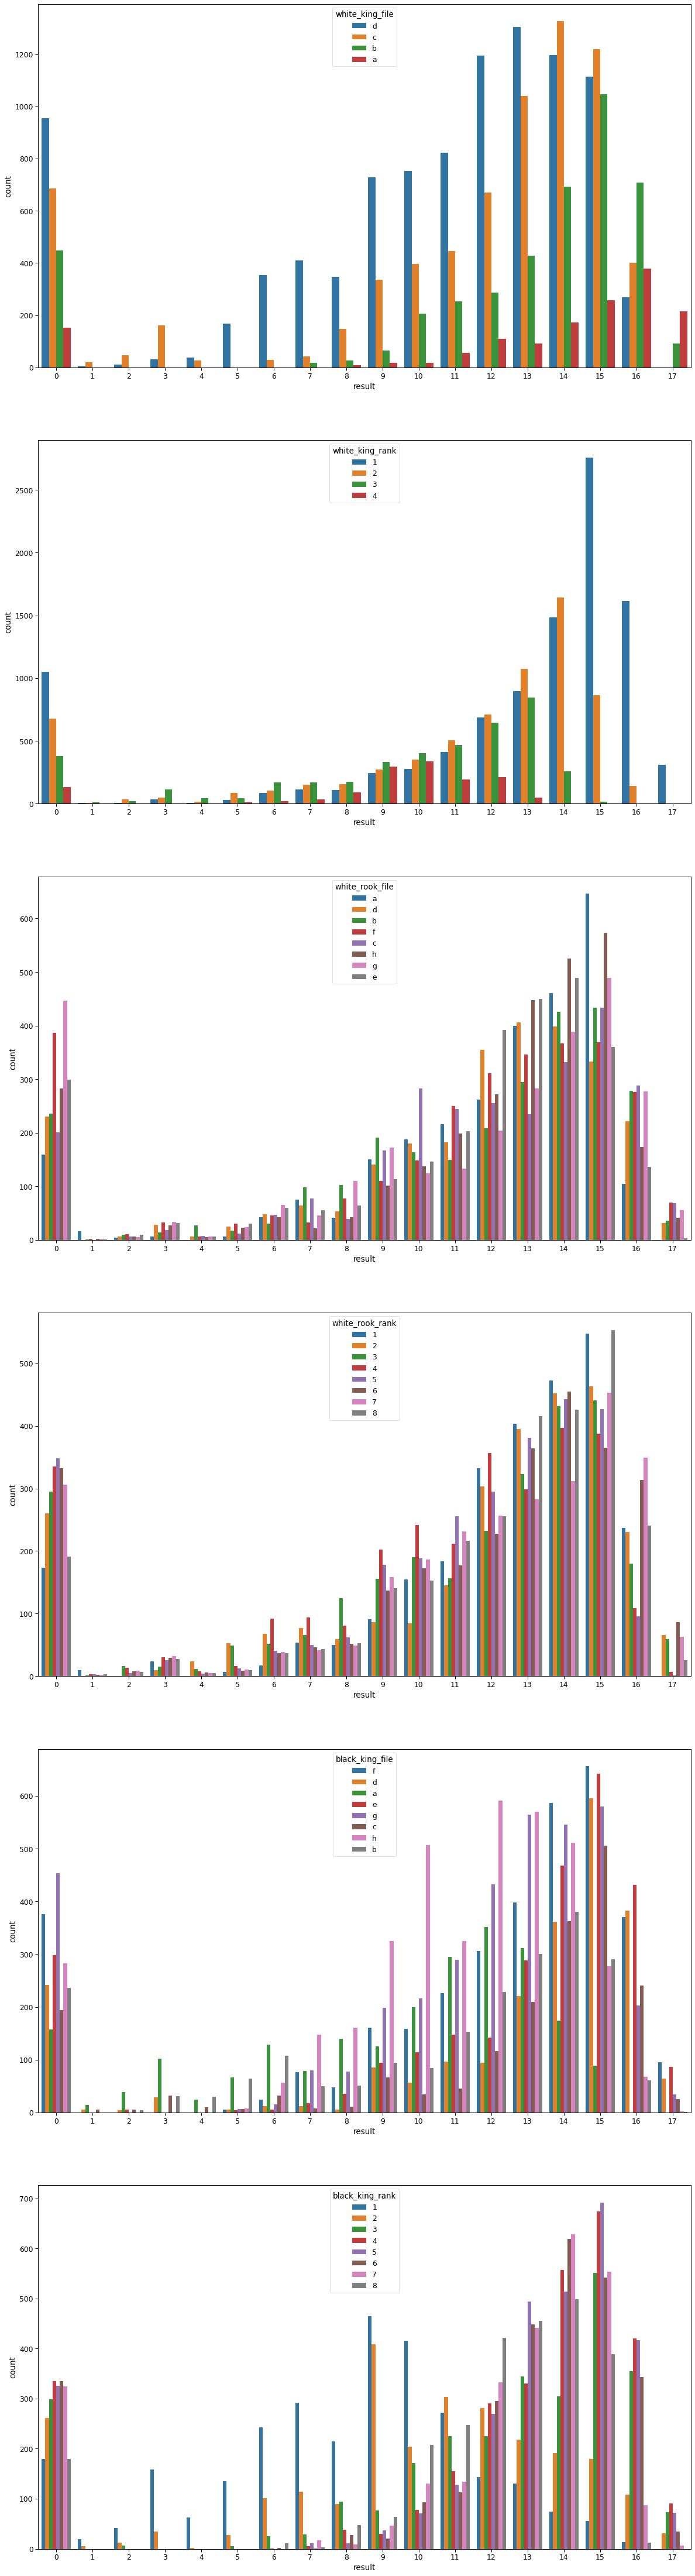

In [12]:
fig, axes = plt.subplots(6,1, figsize = (20, 80))
col_names = ['white_king_file', 'white_king_rank', 'white_rook_file', 'white_rook_rank', 'black_king_file', 'black_king_rank']
for col, ax in zip(col_names, axes.flatten()):
    sns.countplot(x="result",hue=col, data=data, ax=ax)

### Wykresy położenia figur szachowych

In [13]:
def display_chess_board(chessman_file, chessman_rank, plot_title, data):
    chessman_matrix = [[0 for i in range(8)] for j in range(8)]

    tmp_data = data.loc[:,[chessman_rank, chessman_file]]

    for i in range(data.shape[0]):
        chessman_matrix[ rank[tmp_data.loc[i, chessman_rank]-1] -1][tmp_data.loc[i, chessman_file]-1] += 1

    plt.figure(figsize = (14, 12))
    plt.title(plot_title, fontsize = 18)

    sns.heatmap(chessman_matrix, xticklabels=file, yticklabels=rank, annot=True, fmt="d")
    plt.show()

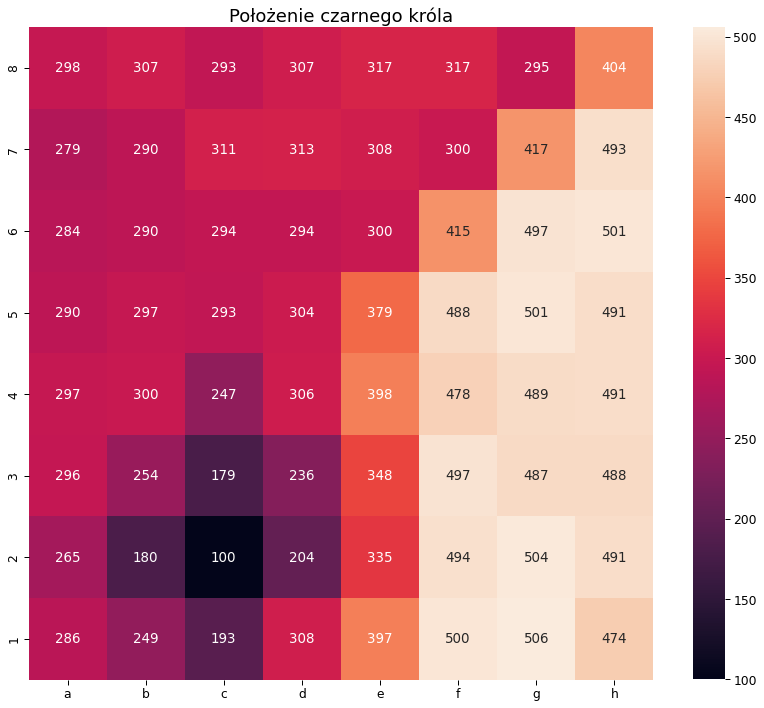

In [14]:
my_dict = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8}

for key in my_dict.keys():
    data1.loc[data1["black_king_file"] == key, "black_king_file"] = my_dict[key]
for key in my_dict.keys():
    data1.loc[data1["white_king_file"] == key, "white_king_file"] = my_dict[key]
for key in my_dict.keys():
    data1.loc[data1["white_rook_file"] == key, "white_rook_file"] = my_dict[key]

rank = [8,7,6,5,4,3,2,1]
file = ["a","b","c","d","e","f","g","h"]

display_chess_board(chessman_file = 'black_king_file', chessman_rank = 'black_king_rank',
                    plot_title = 'Położenie czarnego króla', data = data1)

Z powyższego wyniku widać, że początkowe położenie czarnego króla może być w dowolnym miejscu na planszy. Dodatkowo, są pewne duże obszary, na których czarny król startuje dokładnie tyle samo razy.

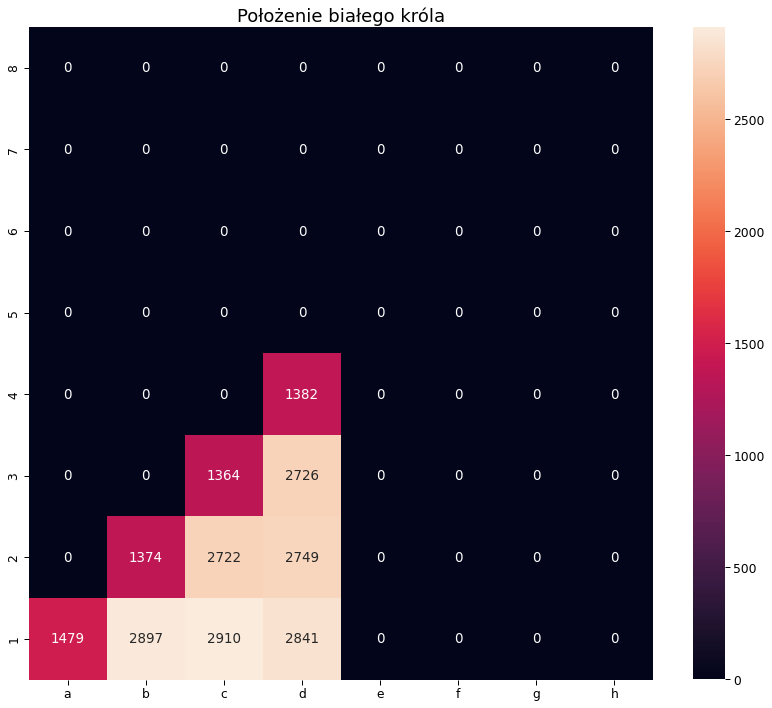

In [15]:
display_chess_board(chessman_file = 'white_king_file', chessman_rank = 'white_king_rank',
                    plot_title = 'Położenie białego króla', data = data1)

Białych figury są w lepszej sytuacji, stąd biały król pojawia się początkowo jedynie na 10 polach. Gdy spojrzymy na położenie czarnego króla, widzimy, że naturalnie najrzadziej występuje on w pobliżu właśnie tych 10 pól.

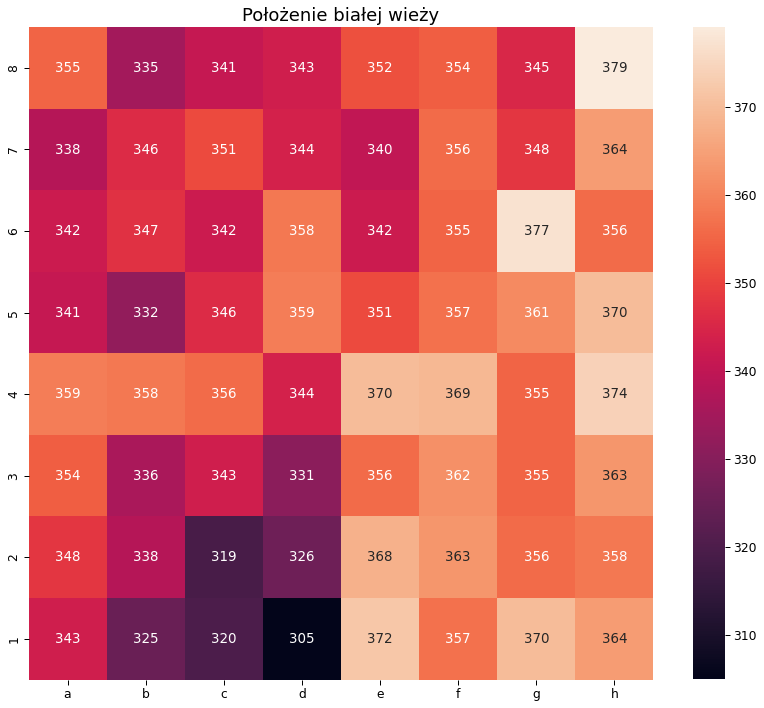

In [16]:
display_chess_board(chessman_file = 'white_rook_file', chessman_rank = 'white_rook_rank',
                    plot_title = 'Położenie białej wieży', data = data1)

W przypadku białej wieży, zgodnie z intuicją, najrzadziej pojawia się ona tam, gdzie jest jej król. Najbardziej "chaotyczne" jest początkowe położenie białej wieży, które jest kluczowe w szukaniu mata w rozważanych sytuacjach.

## Preprocessing i dodawanie zmiennych

### Kodowanie zmiennych kategorycznych

In [17]:
chess_df = data.copy()

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

In [19]:
le = LabelEncoder()

integer_encoded = le.fit_transform(data["black_king_file"])

chess_df["black_king_file"] = integer_encoded + 1

In [20]:
le = LabelEncoder()

integer_encoded = le.fit_transform(data["white_rook_file"])

chess_df["white_rook_file"] = integer_encoded + 1

In [21]:
le = LabelEncoder()

integer_encoded = le.fit_transform(data["white_king_file"])

chess_df["white_king_file"] = integer_encoded + 1

In [22]:
chess_df["result"].sample(5)

14194     9
17390    14
95        0
15143    15
10695    12
Name: result, dtype: int32

### Dodawanie nowych kolumn

In [23]:
chess_df["kings_distance_rank"] = abs((chess_df["black_king_rank"]) - (chess_df["white_king_rank"]))
chess_df["kings_distance_file"] = abs((chess_df["black_king_file"]) - (chess_df["white_king_file"]))
chess_df["kings_distance_sum"] = (chess_df["kings_distance_rank"]) + (chess_df["kings_distance_file"])
chess_df["kings_distance_metric"] = np.maximum(chess_df["kings_distance_rank"], chess_df["kings_distance_file"])
rank = "black_king_rank"
file = "black_king_file"
chess_df["black_king_top_left_corner_distance"] = np.maximum(abs(8 - chess_df[rank]),abs(1 - chess_df[file]))
chess_df["black_king_top_right_corner_distance"] = np.maximum(abs(8 - chess_df[rank]),abs(8 - chess_df[file]))
chess_df["black_king_bottom_left_corner_distance"] = np.maximum(abs(1 - chess_df[rank]),abs(1 - chess_df[file]))
chess_df["black_king_bottom_right_corner_distance"] = np.maximum(abs(1 - chess_df[rank]),abs(8 - chess_df[file]))
chess_df["black_king_nearest_corner_distance"] = np.minimum(np.minimum(chess_df["black_king_top_left_corner_distance"], chess_df["black_king_top_right_corner_distance"]), np.minimum(chess_df["black_king_bottom_left_corner_distance"], chess_df["black_king_bottom_right_corner_distance"]))

chess_df["black_king_nearest_side_distance"] = np.minimum(np.minimum( abs(chess_df[rank] - 8), abs(chess_df[rank] - 1) ), np.minimum( abs(chess_df[file] - 8), abs(chess_df[file] - 1) ))

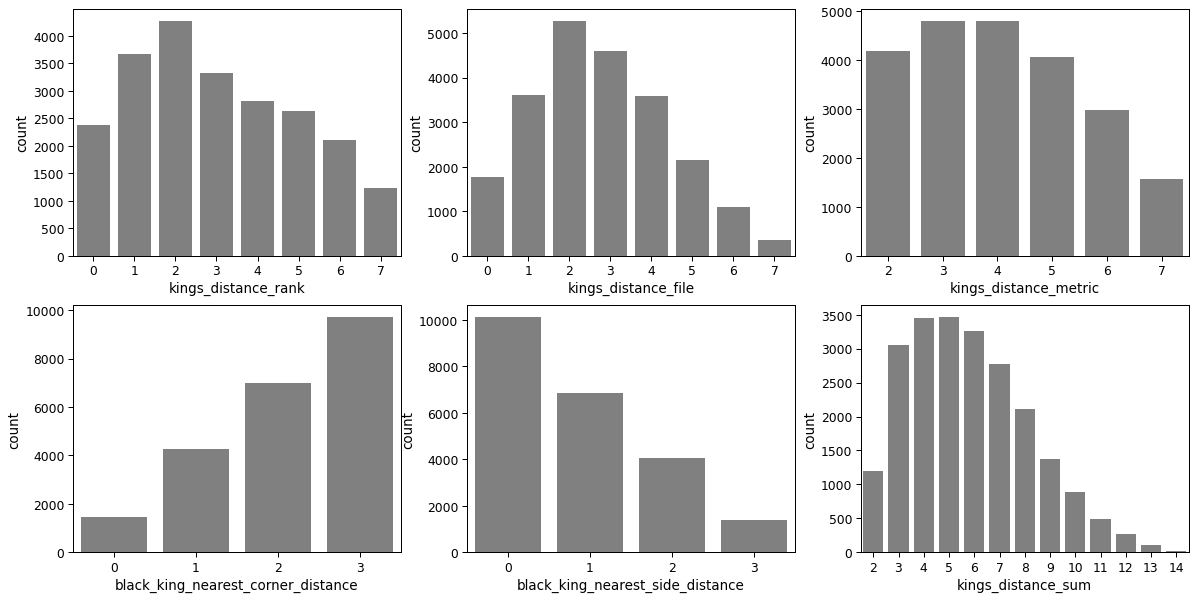

In [24]:
fig, axes = plt.subplots(2,3, figsize = (20, 10))
cols = ["kings_distance_rank", "kings_distance_file", "kings_distance_metric", "black_king_nearest_corner_distance", "black_king_nearest_side_distance", "kings_distance_sum"]

for col, ax in zip(chess_df.loc[:,cols].columns, axes.flatten()):
    sns.countplot(x=col, data=chess_df, ax=ax, color='gray')

### Skalowanie zmiennych opisujących położenie figur

In [25]:
col_names = list(chess_df.columns)
col_names.pop(6) # remove result

min_max_scaler = MinMaxScaler()

for col in col_names:
    scaled_col = min_max_scaler.fit_transform(chess_df[col].values.reshape(-1, 1))
    chess_df[col] = scaled_col

In [26]:
chess_df.head()

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result,kings_distance_rank,kings_distance_file,kings_distance_sum,kings_distance_metric,black_king_top_left_corner_distance,black_king_top_right_corner_distance,black_king_bottom_left_corner_distance,black_king_bottom_right_corner_distance,black_king_nearest_corner_distance,black_king_nearest_side_distance
0,1.000000,0.666667,0.000000,0.000000,0.714286,0.428571,13,0.142857,0.285714,0.083333,0.0,0.714286,0.571429,0.714286,0.428571,1.000000,0.666667
1,1.000000,0.666667,0.428571,0.714286,0.428571,0.857143,0,0.571429,0.000000,0.166667,0.4,0.428571,0.571429,0.857143,0.857143,1.000000,0.333333
2,0.666667,0.000000,0.142857,0.428571,0.000000,0.285714,0,0.285714,0.285714,0.166667,0.0,0.714286,1.000000,0.285714,1.000000,0.666667,0.000000
3,0.333333,0.000000,0.714286,1.000000,0.428571,0.428571,16,0.428571,0.285714,0.250000,0.2,0.571429,0.571429,0.428571,0.571429,1.000000,1.000000
4,0.666667,0.000000,0.285714,0.714286,0.571429,0.857143,14,0.857143,0.285714,0.500000,0.8,0.571429,0.428571,0.857143,0.857143,1.000000,0.333333


### Generowanie automatycznego raportu

## EDA - część 2. (Heat maps)

<AxesSubplot:>

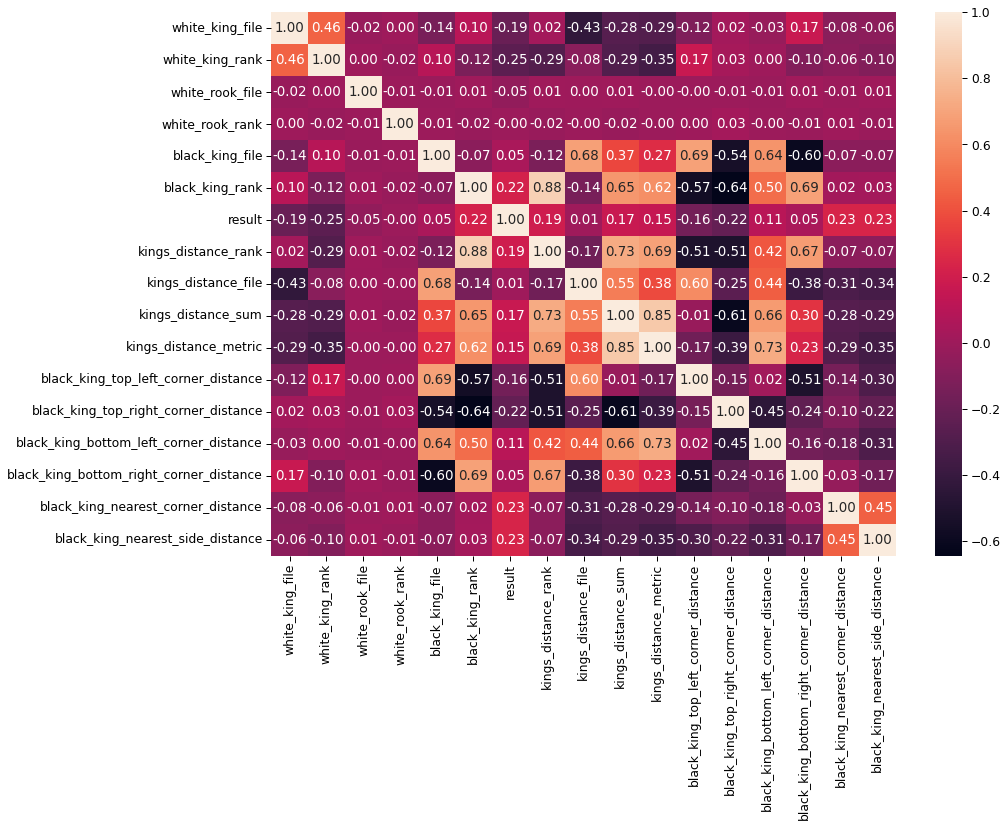

In [27]:
plt.figure(figsize=(14,10))
corr1 = chess_df.corr()
sns.heatmap(corr1, xticklabels=corr1.columns.values, yticklabels=corr1.columns.values, annot=True, fmt=".2f")

<AxesSubplot:>

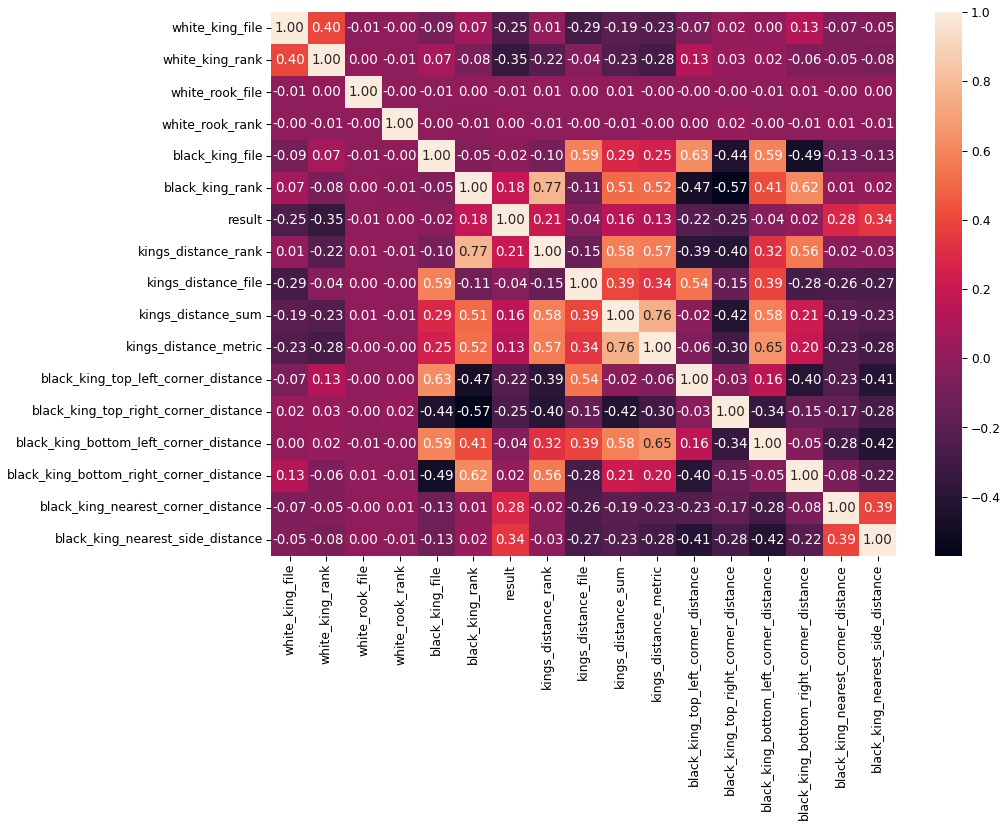

In [28]:
plt.figure(figsize=(14,10))
corr2 = chess_df.corr(method = 'kendall')
sns.heatmap(corr2, xticklabels=corr2.columns.values, yticklabels=corr2.columns.values, annot=True, fmt=".2f")

<AxesSubplot:>

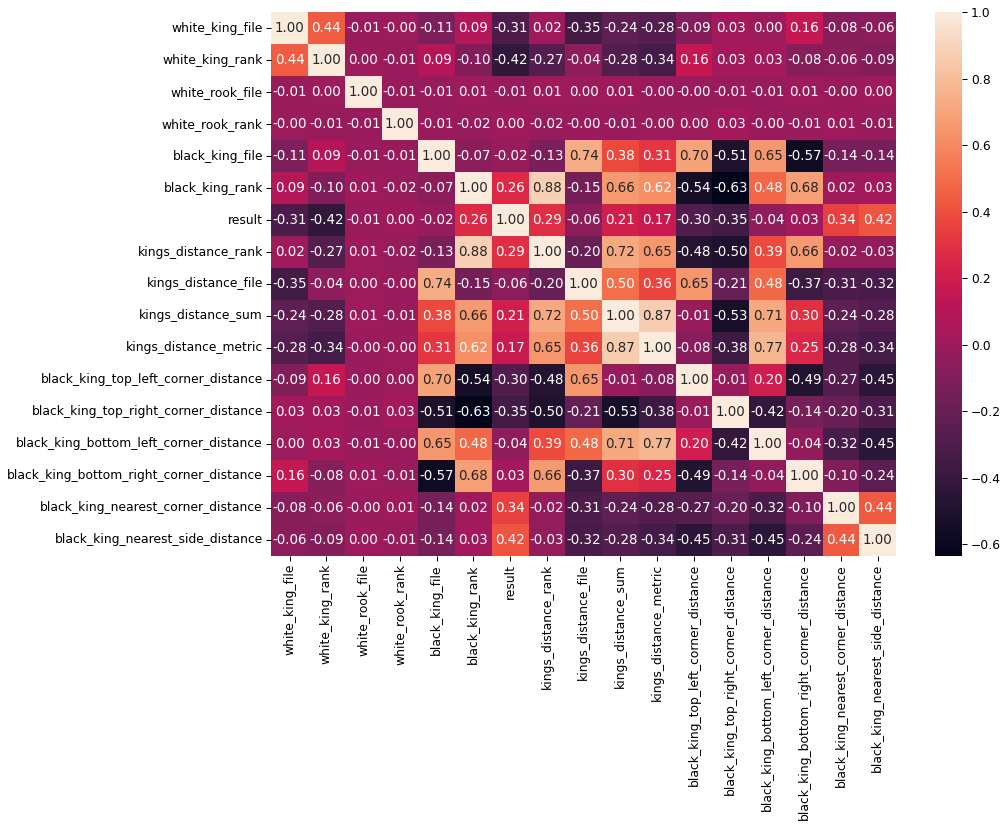

In [29]:
plt.figure(figsize=(14,10))
corr3 = chess_df.corr(method = 'spearman')
sns.heatmap(corr3, xticklabels=corr3.columns.values, yticklabels=corr3.columns.values, annot=True, fmt=".2f")

### Zmiana kierunku

In [30]:
negative_corr_list = list(pd.DataFrame(corr1.loc[(corr1["result"] < 0) & (corr1["result"] != 1), "result"]).index)

for col in negative_corr_list:
    chess_df[col] = chess_df[col]*(-1)

### Wykresy zależności zmiennych których moduł współczynnika korelacji był >= 0.6

In [31]:
correlation_value = 0.6
correlation = chess_df.corr(method = 'spearman')
columns = chess_df.columns

correlation_col_names = []
n = 0
for col_name in columns:
    if n != 0:
        correlation_tmp = correlation.iloc[0:n, [n]]
        tmp = correlation_tmp.loc[(abs(correlation_tmp[col_name]) >= correlation_value), col_name].to_frame()
        if not tmp.empty:
            index = tmp.index.tolist()
            for i in index:
                tmp_list = [col_name, i]
                correlation_col_names.append(tmp_list)
    n += 1
correlation_col_names

[['kings_distance_rank', 'black_king_rank'],
 ['kings_distance_file', 'black_king_file'],
 ['kings_distance_sum', 'black_king_rank'],
 ['kings_distance_sum', 'kings_distance_rank'],
 ['kings_distance_metric', 'black_king_rank'],
 ['kings_distance_metric', 'kings_distance_rank'],
 ['kings_distance_metric', 'kings_distance_sum'],
 ['black_king_top_left_corner_distance', 'black_king_file'],
 ['black_king_top_left_corner_distance', 'kings_distance_file'],
 ['black_king_top_right_corner_distance', 'black_king_rank'],
 ['black_king_bottom_left_corner_distance', 'black_king_file'],
 ['black_king_bottom_left_corner_distance', 'kings_distance_sum'],
 ['black_king_bottom_left_corner_distance', 'kings_distance_metric'],
 ['black_king_bottom_right_corner_distance', 'black_king_rank'],
 ['black_king_bottom_right_corner_distance', 'kings_distance_rank']]

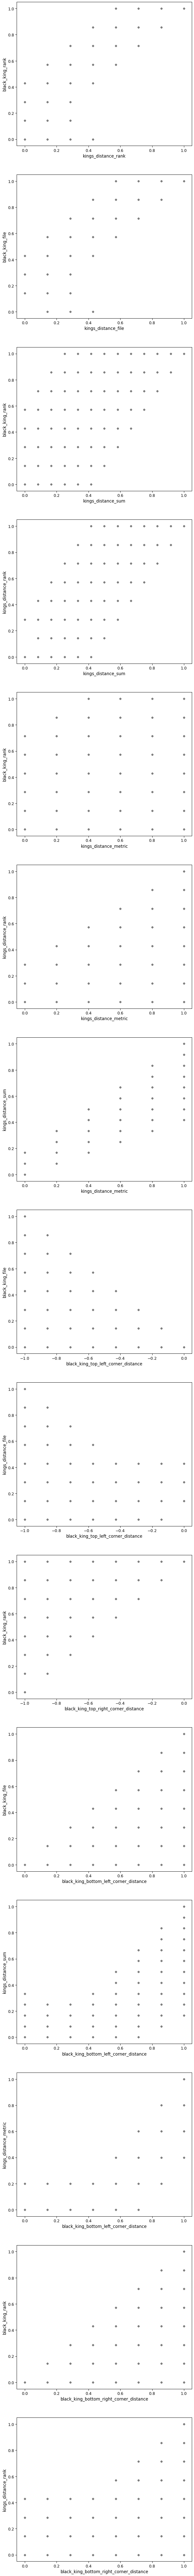

In [32]:
n = len(correlation_col_names)
fig, ax = plt.subplots(n, figsize=(10, 10*n))
i = 0
correlation_col_names_new = correlation_col_names[:len(correlation_col_names)]

for x, y in correlation_col_names_new:
    ax[i].scatter(x = chess_df[x], y = chess_df[y], color='gray')
    ax[i].set_xlabel(x)
    ax[i].set_ylabel(y)
    i += 1

plt.show()

Na powyższych wykresach widzimy tylko dodatnie zależności między konkretnymi kolumnami. Współczynnik korelacji dla żadnej pary kolumn nie wyniósł mniej niż 0.6.

### Generowanie raportu w pandas profiling

In [33]:
# from pandas_profiling import ProfileReport

# report = ProfileReport(chess_df, minimal=True)
# report.to_widgets()
# report.to_file(output_file="pandas_profiling_raport.html")

## Podsumowanie EDA

Celem powyższej części pracy było dokonanie wstępnej analizy zbioru danych o szachach oraz odpowiednie zmodyfikowanie wartości pewnych kolumn. Dotyczyło do głównie tych zawieracjące litery dla zmiennych z dopiskiem _file (zostały zamienione na cyfry) oraz kolumny result, gdzie wartości słowne zamienione zostały na liczby, a wartość draw na -1. Ponadto dodano kolumny określajhące odległość między królami w pionie (kings_distance_rank), poziomie (kings_distance_file) i sumarycznie (kings_distance_sum). Ostatnim etapem modyfikacji danych było przeskaloanie wartości. Dodatkowo w wyniku analizy zbioru uzyskane zostały następujące wnioski:

* Zmienne white_rook_rank, white_rook_file oarz black_king_rank mają rozkład zbliżony do jednostajnego.

* Rozkład zmiennej result jest skośny w lewostronnie pomimo dużej ilości obserwacji dla wartości draw. Potwierdzone zostało to tym, jakie relacje występują między średnią, medianą oraz modą.

* Delikatan skosność prawostronna rozkładu zmiennej kings_distance_sum.

* 5 różnych par zmiennych ma dodatnie współczynniki korelacji powyżej 0.5 (spójrz na sekcję Heat map).

* Położenie czarnego króla jest odwrotne do białego (rzadziej pojawia się tam, gdzie często występuje król biały).

* Król biały porusza się jedynie na małym obszarze planszy.

* Rozkład poołożenia białej wieży jest podobny po rozkładu położeń czarnego króla.

# Modelowanie

## Przygotowania

### Podział danych na zbiór treningowy, walidacyjny oraz testowy.

In [34]:
X = chess_df.drop("result", axis=1)
y = chess_df["result"]
y = y.astype('int')

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=420, test_size=0.125)

# X_train.to_csv("X_train.csv")
# y_train.to_csv("y_train.csv")
# X_val.to_csv("X_val.csv")
# y_val.to_csv("y_val.csv")

Proporcje dobrane sa tak by zbiory były podzielone w na 70%/10%/20%

### Wczytanie pakietów oraz zdefiniowanie używanych funkcji

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
import shap

In [36]:
def generate_conf_matrix(clf, X_train, y_train):
  y_pred_cross = cross_val_predict(clf, X_train, y_train, cv=5)
  conf_matrix = confusion_matrix(y_train, y_pred_cross)
  plt.matshow(conf_matrix, cmap=plt.cm.gray)
  plt.show()

Mimo tego, że rozważany przez nas problem dotyczy klasyfikacji, do metryk oceniających jakość wyniku dodaliśmy również RMSE, ponieważ istotną różnicą jest czy model zwrócił 4 czy 14 w sytuacji gdy poprawnym wynikiem było 3.

In [41]:
def show_model_metrics(model, X_val, y_val):
    y_pred = model.predict(X_val)
    print(f"F1 score: {f1_score(y_val, y_pred, average=None)}")
    print(f"F1 score micro: {f1_score(y_val, y_pred, average='micro')}")
    print(f"F1 score weighted: {f1_score(y_val, y_pred, average='weighted')}")
    print(f"Precision score: {precision_score(y_val, y_pred, average=None)}")
    print(f"Recall score: {recall_score(y_val, y_pred, average=None)}")
    print(f"RMSE Error: {mean_squared_error(y_val, y_pred)}")

## Pojedyncze klasyfikatory

### One vs One

In [42]:
ovo_clf = OneVsOneClassifier(LogisticRegression())

ovo_clf.fit(X_train, y_train)
print('Train set')
show_model_metrics(ovo_clf, X_train, y_train)
print('-----------------------------------------------------------')
print('Val set')
show_model_metrics(ovo_clf, X_val, y_val)

Train set
F1 score: [0.07791253 0.         0.         0.70217918 0.         0.36764706
 0.41621622 0.41081081 0.04480652 0.41901557 0.37053571 0.19361084
 0.33002427 0.34179766 0.37102759 0.50340136 0.47719516 0.30933333]
F1 score micro: 0.36994602301660046
F1 score weighted: 0.3468172525660696
Precision score: [0.14002642 0.         0.         0.6092437  0.         0.40983607
 0.36666667 0.46769231 0.45833333 0.35904831 0.40806293 0.3003003
 0.29437229 0.34001604 0.35581683 0.424      0.45937873 0.51785714]
Recall score: [0.05397149 0.         0.         0.82857143 0.         0.33333333
 0.48125    0.36626506 0.0235546  0.5030303  0.33932952 0.14285714
 0.37550201 0.34359806 0.3875969  0.61939356 0.49644932 0.22053232]
RMSE Error: 25.15139016193095
-----------------------------------------------------------
Val set
F1 score: [0.07253886 0.         0.         0.65116279 0.         0.17142857
 0.45925926 0.41121495 0.02941176 0.42541436 0.3037037  0.18796992
 0.35703002 0.35324675 0.357

### One vs Rest

In [39]:
ovr_clf = OneVsRestClassifier(SVC())

ovr_clf.fit(X_train, y_train)
print('Train set')
show_model_metrics(ovr_clf, X_train, y_train)
print('-----------------------------------------------------------')
print('Val set')
show_model_metrics(ovr_clf, X_val, y_val)

Train set
F1 score: [0.69721116 0.60606061 0.09375    0.69387755 0.03225806 0.53136531
 0.50632911 0.52688172 0.28805621 0.39579685 0.48516027 0.38315107
 0.41900777 0.46855346 0.43093497 0.57968498 0.38308458 0.15141956]
F1 score micro: 0.499083409715857
F1 score weighted: 0.4768813339942389
Precision score: [0.54103429 0.83333333 0.33333333 0.53968254 0.11111111 0.59504132
 0.60085837 0.47572816 0.31782946 0.46887967 0.47009202 0.4424696
 0.51772526 0.52570565 0.50201703 0.47723096 0.53534183 0.44444444]
Recall score: [0.98014257 0.47619048 0.05454545 0.97142857 0.01886792 0.48
 0.4375     0.59036145 0.2633833  0.34242424 0.50122649 0.33785714
 0.35190763 0.4226094  0.37748568 0.7381554  0.29825694 0.09125475]
RMSE Error: [16.45798961]
-----------------------------------------------------------
Val set
F1 score: [0.70179949 0.         0.         0.62068966 0.         0.25806452
 0.51666667 0.47482014 0.28301887 0.45185185 0.36085627 0.28196721
 0.34913793 0.42318841 0.39784946 0.5757

Predykcyjność ogólna obu klasyfikatorów nie jest satysfakcjonująca, jednakże warto zauważyć, że oba dobrze sobie radzą z rozpoznawaniem remisów. Przy odpowiednim doborze parametrów pewnie predykcyjność remisów byłaby bardzo wysoka. Pomimo tego nie będziemy zajmować się tego typu klasyfikatorami, ponieważ nie dają one większej perspektywy do zwiekszenia predykcyjności.

### XGBoost

#### Predykcyjność z domyślnymi parametrami

In [43]:
xgb_clf = xgb.XGBClassifier(random_state=1,
                    booster='gbtree', 
                    use_label_encoder=False,
                     verbosity = 0)
xgb_clf.fit(X_train, y_train)

print('Train set')
show_model_metrics(xgb_clf, X_train, y_train)
print('-----------------------------------------------------------')
print('Val set')
show_model_metrics(xgb_clf, X_val, y_val)

Train set
F1 score: [0.99771283 1.         1.         1.         1.         1.
 0.99530516 0.98676294 0.9752422  0.96370968 0.94749795 0.93428571
 0.91601116 0.89225107 0.90454469 0.93850728 0.94880763 0.98666667]
F1 score micro: 0.9385375292799674
F1 score weighted: 0.938429438732714
Precision score: [0.99594115 1.         1.         1.         1.         1.
 0.9968652  0.98557692 0.98051948 0.96177062 0.95061728 0.93428571
 0.92611596 0.90053652 0.90684282 0.92992248 0.93483709 0.98854962]
Recall score: [0.99949084 1.         1.         1.         1.         1.
 0.99375    0.98795181 0.97002141 0.96565657 0.94439902 0.93428571
 0.9061245  0.88411669 0.90225817 0.94725205 0.96320207 0.98479087]
RMSE Error: 0.1794480089622161
-----------------------------------------------------------
Val set
F1 score: [0.97849462 1.         1.         1.         0.9        0.85714286
 0.90909091 0.81415929 0.8        0.85893417 0.77227723 0.72988506
 0.71161049 0.74867725 0.77239709 0.84253579 0.85253

In [44]:
scores = cross_val_score(xgb_clf, X_train, y_train, cv=6)
scores

array([0.80476627, 0.81607088, 0.82340361, 0.81973724, 0.80843263,
       0.79682249])

#### Dobór hiperparametrów

Wyjątkowo w tej części nie będzie używany `GridShearch`, bowiem czas wykonywania obliczeń jest zbyt długi.

In [ ]:
xgb_clf1 = xgb.XGBClassifier(random_state=1,
                    booster='gbtree', 
                    use_label_encoder=False,
                     verbosity = 0,
                     learning_rate = 0.15,
                     max_depth=6,
                     gamma=0)
xgb_clf1.fit(X_train, y_train)
xgb_clf1.score(X_val, y_val)

0.7352102637205987

In [ ]:
xgb_clf2 = xgb.XGBClassifier(random_state=1,
                    booster='gbtree', 
                    use_label_encoder=False,
                     verbosity = 0,
                     learning_rate = 0.3,
                     max_depth=6,
                     gamma=0)
xgb_clf2.fit(X_train, y_train)
xgb_clf2.score(X_val, y_val)

0.8121881682109765

In [ ]:
xgb_clf3 = xgb.XGBClassifier(random_state=1,
                    booster='gbtree', 
                    use_label_encoder=False,
                     verbosity = 0,
                     learning_rate = 0.3,
                     max_depth=10,
                     gamma=0)
xgb_clf3.fit(X_train, y_train)
xgb_clf3.score(X_val, y_val)

0.8749109052031362

In [45]:
xgb_clf4 = xgb.XGBClassifier(random_state=1,
                    booster='gbtree', 
                    use_label_encoder=False,
                     verbosity = 0,
                     learning_rate = 0.3,
                     max_depth=10,
                     gamma=0.2)
xgb_clf4.fit(X_train, y_train)
xgb_clf4.score(X_val, y_val)

0.8749109052031362

In [ ]:
xgb_clf5 = xgb.XGBClassifier(random_state=1,
                    booster='gbtree', 
                    use_label_encoder=False,
                     verbosity = 0,
                     learning_rate = 0.3,
                     max_depth=14)
xgb_clf5.fit(X_train, y_train)
xgb_clf5.score(X_val, y_val)

0.8738417676407698

In [46]:
print('Train set')
show_model_metrics(xgb_clf4, X_train, y_train)
print('-----------------------------------------------------------')
print('Val set')
show_model_metrics(xgb_clf4, X_val, y_val)

Train set
F1 score: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.99974906 0.99918963 0.99932569 0.9998421  0.99967732 0.99809524]
F1 score micro: 0.9996944699052857
F1 score weighted: 0.9996944056968439
Precision score: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.99949824 0.99918963 0.99966273 0.99968424 0.99935484 1.        ]
Recall score: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.99918963 0.99898888 1.         1.         0.99619772]
RMSE Error: 0.00030553009471432935
-----------------------------------------------------------
Val set
F1 score: [0.98188406 1.         0.85714286 1.         0.95238095 0.94444444
 0.94488189 0.8245614  0.80952381 0.88957055 0.86013986 0.80898876
 0.8125     0.83745124 0.86761229 0.91157895 0.88317757 0.75      ]
F1 

[0.85548427 0.86770547 0.86739994 0.86953865 0.85548427 0.8588451 ]


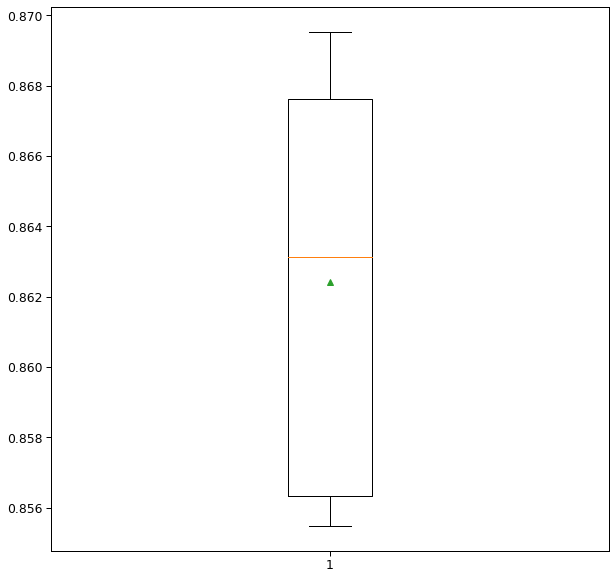

In [ ]:
scores_xgbc = cross_val_score(xgb_clf4, X_train, y_train, cv=6)
print(scores_xgbc)
plt.boxplot(scores_xgbc, showmeans=True)
plt.show()

---

Feature importance

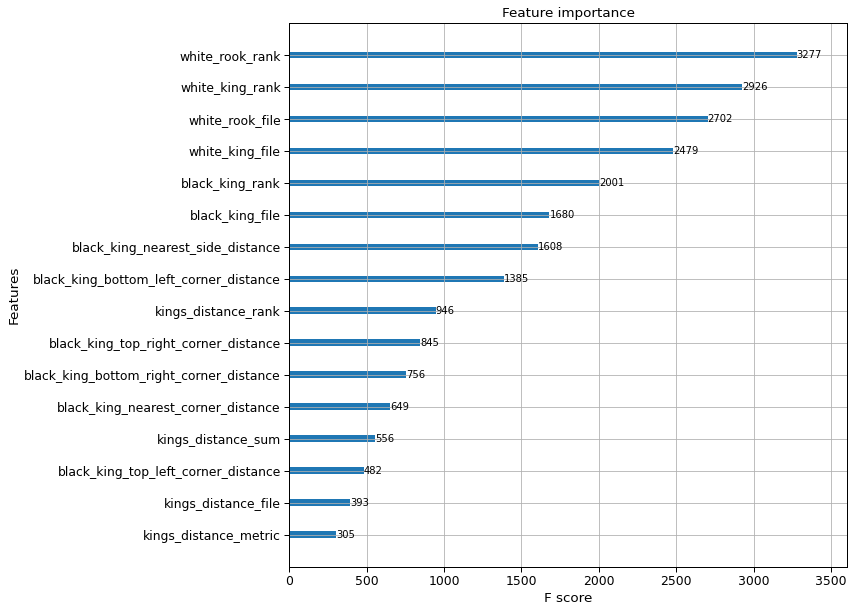

In [ ]:
xgb.plot_importance(model)

### Klasyfikator `KNeighborsClassifier`

In [75]:
model_knc = KNeighborsClassifier()
model_knc.fit(X_train, y_train)

y_pred = model_knc.predict(X_val)
y_pred_proba = model_knc.predict_proba(X_val)

In [76]:
show_model_metrics(model_knc, X_val, y_val)

F1 score: [0.62690707 0.66666667 0.4        0.95       0.47058824 0.25641026
 0.64233577 0.52631579 0.40322581 0.58471761 0.47352025 0.46239554
 0.39458414 0.48656294 0.48166259 0.55902004 0.50241546 0.4057971 ]
F1 score micro: 0.5146115466856735
F1 score weighted: 0.5102710151976737
Precision score: [0.50786517 0.66666667 0.33333333 0.9047619  0.66666667 0.23809524
 0.59459459 0.52631579 0.41666667 0.61971831 0.43930636 0.45856354
 0.40963855 0.55128205 0.49622166 0.5864486  0.50241546 0.58333333]
Recall score: [0.81884058 0.66666667 0.5        1.         0.36363636 0.27777778
 0.6984127  0.52631579 0.390625   0.55345912 0.51351351 0.46629213
 0.38059701 0.43544304 0.46793349 0.53404255 0.50241546 0.31111111]
RMSE Error: 18.360299358517462


In [77]:
scores = cross_val_score(model_knc, X_train, y_train, cv=5)
scores

array([0.51960285, 0.50840122, 0.5305499 , 0.49019608, 0.49121467])

Otrzymana dokładność jest gorsza od wielu wcześniejszych.

### DecisionTreeClassifier

In [47]:
model_dtc = DecisionTreeClassifier(random_state=1)
model_dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

#### Predykcyjność z domyślnymi parametrami

In [48]:
print('Train set')
show_model_metrics(model_dtc, X_train, y_train)
print('-----------------------------------------------------------')
print('Val set')
show_model_metrics(model_dtc, X_val, y_val)

Train set
F1 score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F1 score micro: 1.0
F1 score weighted: 1.0
Precision score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Recall score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
RMSE Error: 0.0
-----------------------------------------------------------
Val set
F1 score: [0.75280899 1.         0.85714286 0.95       0.90909091 0.77419355
 0.88888889 0.85714286 0.76119403 0.87066246 0.81553398 0.78688525
 0.76803119 0.78184111 0.77600979 0.81373569 0.77209302 0.63829787]
F1 score micro: 0.7918745545260156
F1 score weighted: 0.7916339935157944
Precision score: [0.77906977 1.         1.         0.9047619  0.90909091 0.92307692
 0.88888889 0.87272727 0.72857143 0.87341772 0.7826087  0.76595745
 0.80408163 0.77889447 0.80050505 0.79633401 0.74439462 0.6122449 ]
Recall score: [0.72826087 1.         0.75       1.         0.90909091 0.66666667
 0.88888889 0.84210526 0.796875   0.86792453 0.85135135 0.80898876
 0

In [49]:
scores = cross_val_score(model_dtc, X_train, y_train, cv=6)
scores

array([0.76382524, 0.76626948, 0.75679804, 0.75588145, 0.76076994,
       0.75282615])

#### Dobór hiperparametrów

In [ ]:
model_dtc2 = DecisionTreeClassifier(random_state=1)

max_depth = range(1, 22, 1)
criterion = ["gini","entrophy"]
max_features = ["sqrt", "log2", None]
min_samples_split = range(1, 22, 1)
param_grid = dict(max_depth = max_depth, criterion = criterion,
                  max_features = max_features, min_samples_split = min_samples_split)

grid = GridSearchCV(estimator = model_dtc2, param_grid = param_grid,
                            cv = 6, n_jobs=-1, scoring='f1_weighted')

grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.803070 using {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_split': 2}

In [50]:
model_dtc3 = DecisionTreeClassifier(criterion='gini', max_depth=20, max_features=None, min_samples_split=2, random_state=1)
model_dtc3.fit(X_train, y_train)
print('Train set')
show_model_metrics(model_dtc3, X_train, y_train)
print('-----------------------------------------------------------')
print('Val set')
show_model_metrics(model_dtc3, X_val, y_val)

Train set
F1 score: [0.99872871 1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99918167 0.99857245
 0.99749122 0.99777283 0.99932592 0.99905183 0.99870718 0.99618321]
F1 score micro: 0.9987778796211427
F1 score weighted: 0.9987779477654173
Precision score: [0.99746064 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.9978602
 0.99699097 0.99716714 0.99932592 0.99968374 1.         1.        ]
Recall score: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99836468 0.99928571
 0.99799197 0.99837925 0.99932592 0.99842072 0.99741769 0.99239544]
RMSE Error: 0.04995417048579285
-----------------------------------------------------------
Val set
F1 score: [0.75229358 1.         0.85714286 0.95       0.90909091 0.73333333
 0.88188976 0.85714286 0.7518797  0.84984026 0.81789137 0.78888889
 0.77281553 0.78227848 0.76399027 0.81465969 0.7731

[0.75954782 0.76840819 0.75282615 0.75954782 0.75557592 0.75679804]


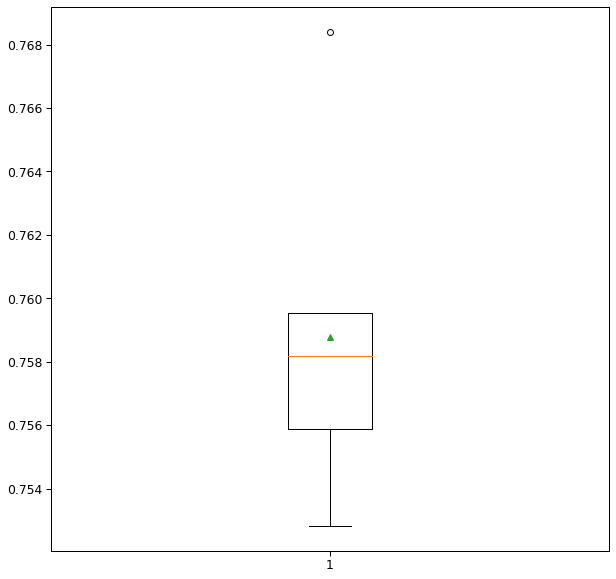

In [ ]:
scores_dtc = cross_val_score(model_dtc3, X_train, y_train, cv=6)
print(scores_dtc)
plt.boxplot(scores_dtc, showmeans=True)
plt.show()

---

Confusion Matrix

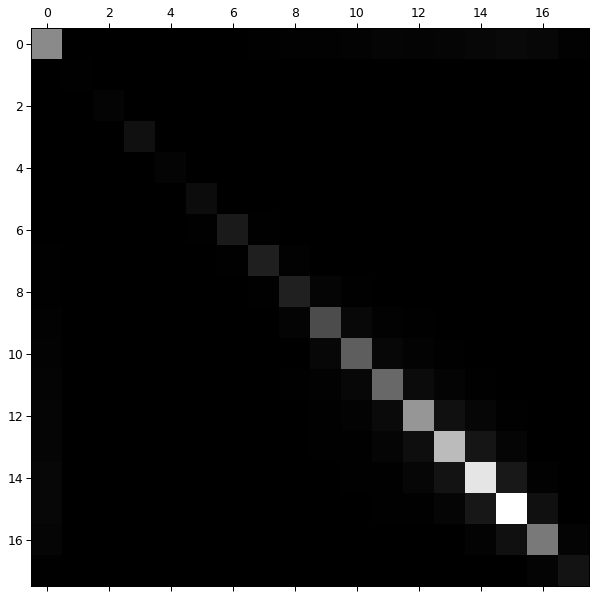

In [ ]:
y_pred_cross_dtc = cross_val_predict(model_dtc3, X_train, y_train, cv=10)
conf_mx_dtc = confusion_matrix(y_train, y_pred_cross_dtc)
plt.matshow(conf_mx_dtc, cmap=plt.cm.gray)
plt.show()

In [ ]:
pd.DataFrame(conf_mx_dtc)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1404,5,1,4,0,4,5,16,30,29,40,58,47,54,75,94,73,25
1,2,18,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,50,0,0,0,3,1,1,0,0,0,0,0,0,0,0,0
3,3,0,2,166,2,1,0,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,3,47,1,1,0,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,3,126,10,2,2,2,1,0,1,1,0,0,0,0
6,3,0,1,0,1,12,264,18,6,3,5,4,2,0,1,0,0,0
7,13,1,1,0,1,3,20,320,25,8,9,9,2,1,1,1,0,0
8,20,0,2,1,1,2,5,16,331,56,13,8,5,5,0,2,0,0
9,24,0,1,0,0,3,6,5,43,768,87,26,15,6,5,1,0,0


### RandomForestClassifier

#### Predykcyjność z domyślnymi parametrami

In [51]:
model_rfc = RandomForestClassifier(random_state=2022)
model_rfc.fit(X_train, y_train)

print('Train set')
show_model_metrics(model_rfc, X_train, y_train)
print('-----------------------------------------------------------')
print('Val set')
show_model_metrics(model_rfc, X_val, y_val)

Train set
F1 score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F1 score micro: 1.0
F1 score weighted: 1.0
Precision score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Recall score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
RMSE Error: 0.0
-----------------------------------------------------------
Val set
F1 score: [0.7844523  1.         0.85714286 1.         0.73684211 0.68421053
 0.83969466 0.81818182 0.67716535 0.78343949 0.65993266 0.65340909
 0.6440678  0.66580311 0.64373464 0.70083682 0.63697105 0.63529412]
F1 score micro: 0.6917320028510335
F1 score weighted: 0.6914565674930544
Precision score: [0.76551724 1.         1.         1.         0.875      0.65
 0.80882353 0.8490566  0.68253968 0.79354839 0.65771812 0.66091954
 0.65019011 0.68169761 0.66666667 0.68930041 0.59090909 0.675     ]
Recall score: [0.80434783 1.         0.75       1.         0.63636364 0.72222222
 0.87301587 0.78947368 0.671875   0.77358491 0.66216216 0.64606742
 0.63805

#### Dobór hiperparametrów

In [ ]:
model_rfc2 = RandomForestClassifier(random_state=2022, n_jobs=-1, criterion='gini')

max_depth = range(4, 17, 4)
max_features = ["sqrt", None]
min_samples_split = range(2, 13, 4)
n_estimators = range(100, 251, 50)
param_grid = dict(max_depth = max_depth,
                  max_features = max_features, min_samples_split = min_samples_split,
                   n_estimators = n_estimators)

grid = GridSearchCV(estimator = model_rfc2, param_grid = param_grid,
                            cv = 6, n_jobs=-1, scoring='f1_weighted')

grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.811046 using {'max_depth': 16, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 250}

In [ ]:
model_rfc2 = RandomForestClassifier(random_state=2022, n_jobs=-1, criterion='gini',
                                    min_samples_split=2, max_features=None)

max_depth = range(16, 42, 4)
n_estimators = range(250, 351, 50)
param_grid = dict(max_depth = max_depth,
                   n_estimators = n_estimators)

grid = GridSearchCV(estimator = model_rfc2, param_grid = param_grid,
                            cv = 6, n_jobs=-1, scoring='f1_weighted')

grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.815566 using {'max_depth': 28, 'n_estimators': 300}

In [52]:
model_rfc3 = RandomForestClassifier(random_state=2022, n_jobs=-1, criterion='gini', max_depth=28, max_features=None, min_samples_split=2, n_estimators=300)
model_rfc3.fit(X_train, y_train)

print('Train set')
show_model_metrics(model_rfc3, X_train, y_train)
print('-----------------------------------------------------------')
print('Val set')
show_model_metrics(model_rfc3, X_val, y_val)

Train set
F1 score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F1 score micro: 1.0
F1 score weighted: 1.0
Precision score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Recall score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
RMSE Error: 0.0
-----------------------------------------------------------
Val set
F1 score: [0.82186949 1.         0.85714286 0.97435897 0.95238095 0.88888889
 0.96       0.88495575 0.75       0.87066246 0.81756757 0.78651685
 0.81869159 0.82564103 0.81517748 0.84963197 0.80361174 0.6746988 ]
F1 score micro: 0.827512473271561
F1 score weighted: 0.8272896434532578
Precision score: [0.80068729 1.         1.         0.95       1.         0.88888889
 0.96774194 0.89285714 0.80357143 0.87341772 0.81756757 0.78651685
 0.82022472 0.83636364 0.84090909 0.83991684 0.75423729 0.73684211]
Recall score: [0.8442029  1.         0.75       1.         0.90909091 0.88888889
 0.95238095 0.87719298 0.703125   0.86792453 0.81756757 0.78651685
 0.

Widać tutaj ciekawą sytuację. Porównyjąc uzyskane wyniki po doborze parametrów oraz te przed doborem mamy w obu przypadkach do czynienia z idealnym dopasdowaniem do zbioru treningowego (to raczej nie dziwi), lecz predykcyjność dla zbioru walidacyjnego jest już znacznie wyższa.

[0.8111824  0.81637641 0.8243202  0.80751604 0.82676444 0.80873816]


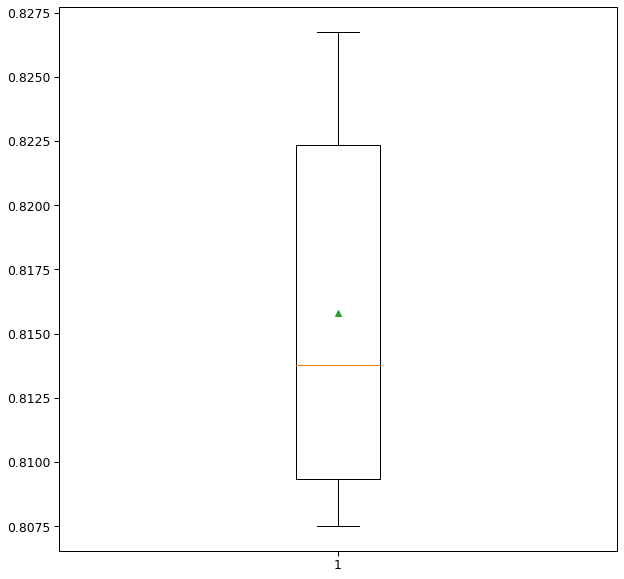

In [ ]:
scores_rfc = cross_val_score(model_rfc3, X_train, y_train, cv=6)
print(scores_rfc)
plt.boxplot(scores_rfc, showmeans=True)
plt.show()

---

Confusion Matrix

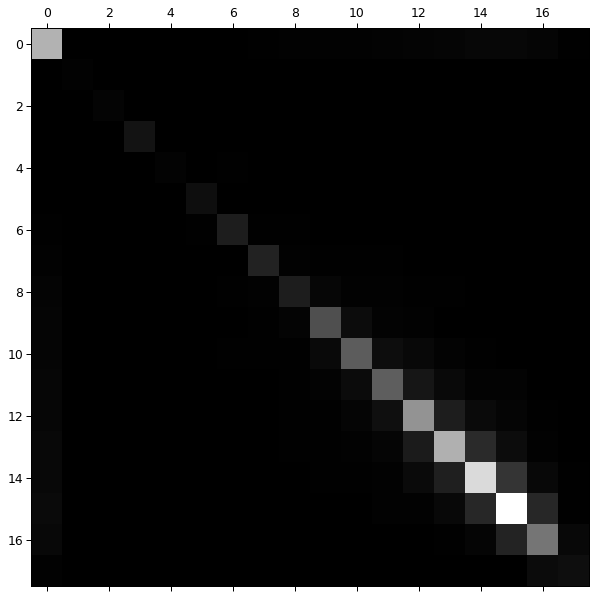

In [ ]:
y_pred_cross_rfc = cross_val_predict(model_rfc3, X_train, y_train, cv=5)
conf_mx_rfc = confusion_matrix(y_train, y_pred_cross_rfc)
plt.matshow(conf_mx_rfc, cmap=plt.cm.gray)
plt.show()

In [ ]:
pd.DataFrame(conf_mx_rfc)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1562,3,1,6,2,3,3,9,24,22,20,30,41,44,65,63,52,14
1,1,18,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,42,1,1,1,3,0,3,2,1,0,1,0,0,0,0,0
3,2,1,1,167,2,0,2,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,4,34,2,11,2,0,0,0,0,0,0,0,0,0,0
5,1,0,0,1,3,124,8,5,3,2,1,0,1,1,0,0,0,0
6,11,0,4,2,3,9,256,10,10,4,5,0,3,1,2,0,0,0
7,18,0,0,0,4,7,6,304,26,14,14,14,4,2,1,1,0,0
8,41,0,4,1,0,0,13,21,256,61,22,20,15,9,1,3,0,0
9,50,0,0,0,0,2,4,13,42,697,106,35,22,7,7,5,0,0


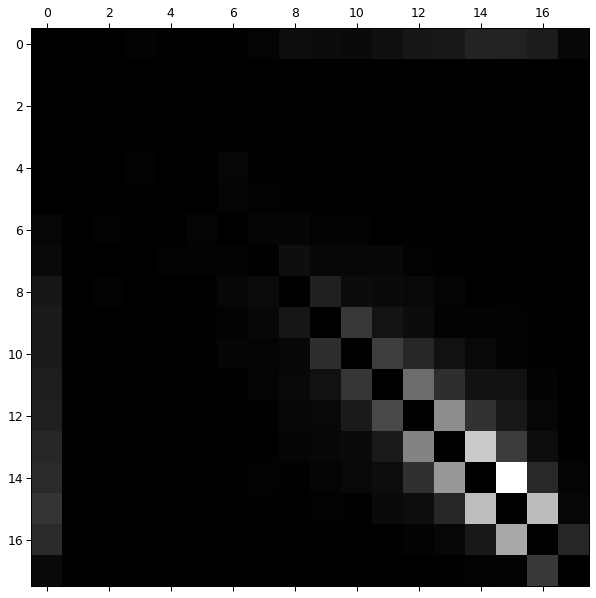

In [ ]:
row_sum = conf_mx_rfc.sum(axis=1, keepdims=True)
norm_conf_mx_rfc = conf_mx_rfc
np.fill_diagonal(norm_conf_mx_rfc, 0)
plt.matshow(norm_conf_mx_rfc, cmap=plt.cm.gray)
plt.show()

In [ ]:
scores = cross_val_score(model_rfc, X_train, y_train, cv=5)
scores

array([0.66751527, 0.67718941, 0.69933809, 0.66997708, 0.66106443])

### Użycie `BaggingClassifier`

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
y_pred_proba = bag_clf.predict_proba(X_test)
print(f1_score(y_test, y_pred, average='micro'))

0.42997148966500354


### Klasyfikator `GaussianNB`

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)
y_pred_proba = nb.predict_proba(X_test)
print(f1_score(y_test, y_pred, average='micro'))

0.23663578047042053


Rezultatem tego podejścia jest najgorsza otrzymana dokładność.

## Metody łączące klasyfikatory

In [53]:
model1 = model_dtc3
model2 = xgb_clf4
model3 = model_rfc3
estimators=[('DecisionTree', model1), ('XGBoost', model2), ('RandomForest', model3)]

### StackingClassifier

In [54]:
stacking_clf = StackingClassifier(estimators=estimators,
                         final_estimator=LogisticRegression(),
                         n_jobs=-1,
                         cv=6)
stacking_clf.fit(X_train, y_train)
print('Train set')
show_model_metrics(stacking_clf, X_train, y_train)
print('-----------------------------------------------------------')
print('Val set')
show_model_metrics(stacking_clf, X_val, y_val)

Train set
F1 score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F1 score micro: 1.0
F1 score weighted: 1.0
Precision score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Recall score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
RMSE Error: 0.0
-----------------------------------------------------------
Val set
F1 score: [0.98729583 1.         0.85714286 1.         1.         0.97142857
 0.95238095 0.85964912 0.848      0.91076923 0.84848485 0.8121547
 0.84916201 0.86375321 0.87439614 0.90736842 0.89095128 0.775     ]
F1 score micro: 0.8866714183891661
F1 score weighted: 0.8864131568339938
Precision score: [0.98909091 1.         1.         1.         1.         1.
 0.95238095 0.85964912 0.86885246 0.89156627 0.84563758 0.79891304
 0.84758364 0.8772846  0.88943489 0.89791667 0.85714286 0.88571429]
Recall score: [0.98550725 1.         0.75       1.         1.         0.94444444
 0.95238095 0.85964912 0.828125   0.93081761 0.85135135 0.8258427
 0.85074627 

Confusion Matrix

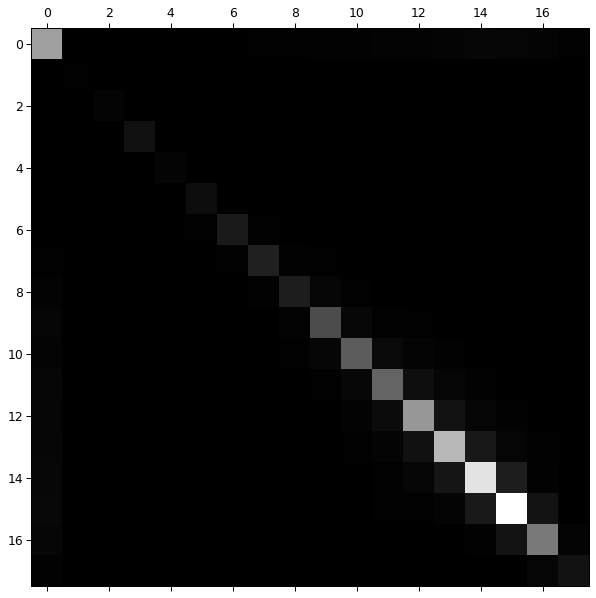

In [ ]:
y_pred_cross_stack = cross_val_predict(stacking_clf, X_train, y_train, cv=5)
conf_mx_stack = confusion_matrix(y_train, y_pred_cross_stack)
plt.matshow(conf_mx_stack, cmap=plt.cm.gray)
plt.show()

### VotingClassifier

#### Hard voting

In [55]:
voting_hard_clf = VotingClassifier(estimators=estimators, voting='hard')
voting_hard_clf.fit(X_train,y_train)
print('Train set')
show_model_metrics(voting_hard_clf, X_train, y_train)
print('-----------------------------------------------------------')
print('Val set')
show_model_metrics(voting_hard_clf, X_val, y_val)

Train set
F1 score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F1 score micro: 1.0
F1 score weighted: 1.0
Precision score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Recall score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
RMSE Error: 0.0
-----------------------------------------------------------
Val set
F1 score: [0.85365854 1.         0.85714286 0.95       0.95238095 0.91428571
 0.953125   0.89285714 0.8        0.8875     0.85618729 0.80672269
 0.80675422 0.83033419 0.83148831 0.87276551 0.83255814 0.69879518]
F1 score micro: 0.8446186742694227
F1 score weighted: 0.8441981737248452
Precision score: [0.82214765 1.         1.         0.9047619  1.         0.94117647
 0.93846154 0.90909091 0.81967213 0.88198758 0.84768212 0.80446927
 0.81132075 0.84334204 0.8622449  0.86278586 0.80269058 0.76315789]
Recall score: [0.88768116 1.         0.75       1.         0.90909091 0.88888889
 0.96825397 0.87719298 0.78125    0.89308176 0.86486486 0.80898876
 0

[0.82493126 0.83287504 0.83470822 0.82523679 0.83470822 0.81607088]


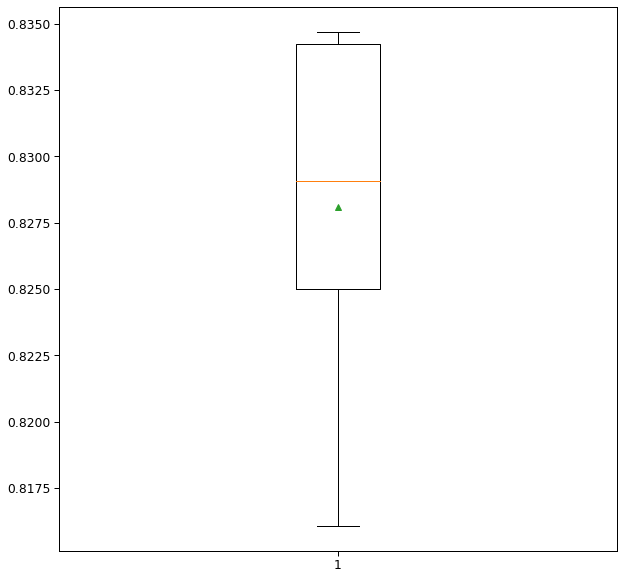

In [56]:
scores_voting_hard_clf = cross_val_score(voting_hard_clf, X_train, y_train, cv=6)
print(scores_voting_hard_clf)
plt.boxplot(scores_voting_hard_clf, showmeans=True)
plt.show()

#### Soft voting wieghted

In [57]:
voting_soft_weighted_clf = VotingClassifier(estimators=estimators, voting='soft', weights=[0.2, 0.6, 0.2])
voting_soft_weighted_clf.fit(X_train, y_train)
print('Train set')
show_model_metrics(voting_soft_weighted_clf, X_train, y_train)
print('-----------------------------------------------------------')
print('Val set')
show_model_metrics(voting_soft_weighted_clf, X_val, y_val)

Train set
F1 score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F1 score micro: 1.0
F1 score weighted: 1.0
Precision score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Recall score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
RMSE Error: 0.0
-----------------------------------------------------------
Val set
F1 score: [0.96785714 1.         0.85714286 1.         1.         0.94117647
 0.93023256 0.85714286 0.84126984 0.90402477 0.86101695 0.82285714
 0.83394834 0.85271318 0.87061669 0.90585774 0.87906977 0.74074074]
F1 score micro: 0.8799002138275125
F1 score weighted: 0.8793099786175143
Precision score: [0.95422535 1.         1.         1.         1.         1.
 0.90909091 0.87272727 0.85483871 0.8902439  0.86394558 0.8372093
 0.82481752 0.8707124  0.88669951 0.8909465  0.84753363 0.83333333]
Recall score: [0.98188406 1.         0.75       1.         1.         0.88888889
 0.95238095 0.84210526 0.828125   0.91823899 0.85810811 0.80898876
 0.84328358

[0.85670639 0.87076077 0.87014971 0.86862206 0.85762298 0.85609533]


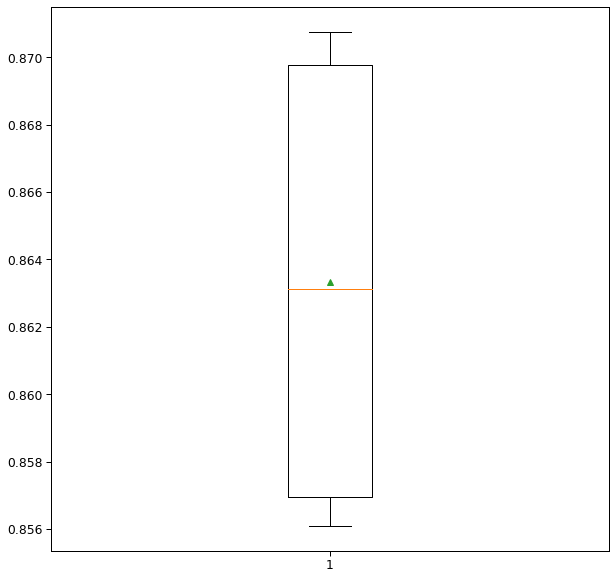

In [58]:
scores_voting_soft_weighted_clf = cross_val_score(voting_soft_weighted_clf, X_train, y_train, cv=6)
print(scores_voting_soft_weighted_clf)
plt.boxplot(scores_voting_soft_weighted_clf, showmeans=True)
plt.show()

Confusion Matrix

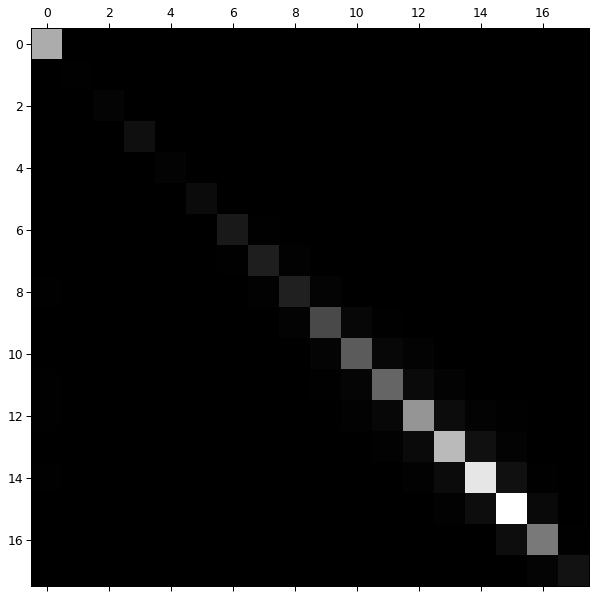

In [60]:
y_pred_cross_soft_weighted = cross_val_predict(voting_soft_weighted_clf, X_train, y_train, cv=10)
conf_mx_soft_weighted = confusion_matrix(y_train, y_pred_cross_soft_weighted)
plt.matshow(conf_mx_soft_weighted, cmap=plt.cm.gray)
plt.show()

In [61]:
pd.DataFrame(conf_mx_soft_weighted)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1926,4,1,5,1,1,1,2,1,1,1,3,2,3,2,4,1,5
1,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,53,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
3,2,0,1,168,2,1,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,2,44,6,1,0,0,0,0,0,0,0,0,0,0,0
5,3,0,0,0,1,134,10,1,0,1,0,0,0,0,0,0,0,0
6,1,0,1,0,1,7,282,14,5,4,3,1,0,0,0,1,0,0
7,7,0,0,0,1,4,13,347,27,7,5,3,1,0,0,0,0,0
8,12,0,0,1,0,1,4,24,361,49,7,2,3,1,0,2,0,0
9,9,0,0,0,0,1,3,6,34,835,82,15,4,1,0,0,0,0


#### Soft voting

In [62]:
voting_soft_clf = VotingClassifier(estimators=estimators, voting='soft')
voting_soft_clf.fit(X_train, y_train)
print('Train set')
show_model_metrics(voting_soft_clf, X_train, y_train)
print('-----------------------------------------------------------')
print('Val set')
show_model_metrics(voting_soft_clf, X_val, y_val)

Train set
F1 score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F1 score micro: 1.0
F1 score weighted: 1.0
Precision score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Recall score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
RMSE Error: 0.0
-----------------------------------------------------------
Val set
F1 score: [0.85361552 1.         0.85714286 0.95       0.90909091 0.8
 0.90625    0.86725664 0.828125   0.87619048 0.83387622 0.81792717
 0.79846449 0.81273885 0.81280788 0.85983264 0.81775701 0.66666667]
F1 score micro: 0.8317890235210263
F1 score weighted: 0.8314085264247836
Precision score: [0.83161512 1.         1.         0.9047619  0.90909091 1.
 0.89230769 0.875      0.828125   0.88461538 0.80503145 0.81564246
 0.82213439 0.81794872 0.84398977 0.84567901 0.7918552  0.66666667]
Recall score: [0.87681159 1.         0.75       1.         0.90909091 0.66666667
 0.92063492 0.85964912 0.828125   0.86792453 0.86486486 0.82022472
 0.7761194  0.807

[0.85670639 0.87076077 0.87014971 0.86862206 0.85762298 0.85609533]


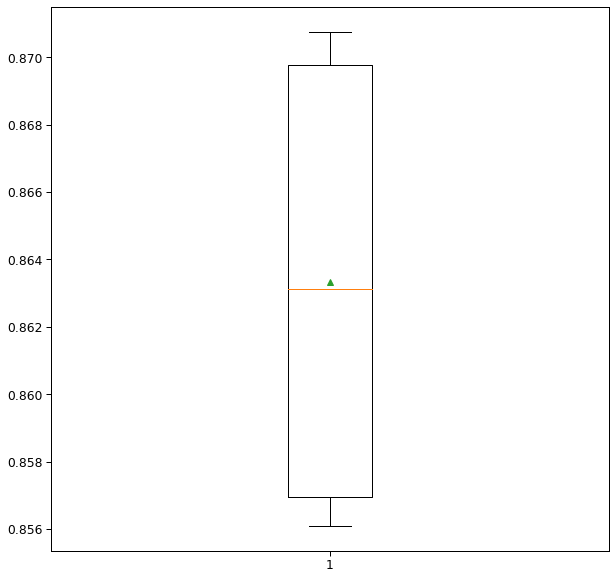

In [63]:
scores_voting_soft_clf = cross_val_score(voting_soft_weighted_clf, X_train, y_train, cv=6)
print(scores_voting_soft_clf)
plt.boxplot(scores_voting_soft_clf, showmeans=True)
plt.show()

Confusion Matrix

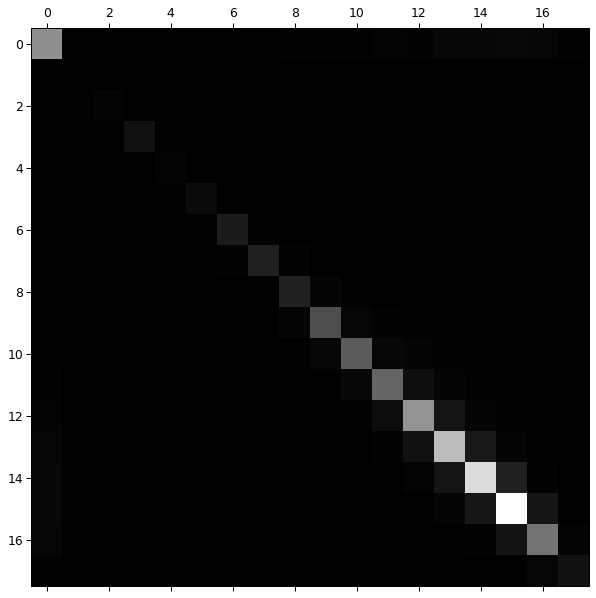

In [ ]:
y_pred_cross_soft = cross_val_predict(model_soft, X_train, y_train, cv=10)
conf_mx_soft = confusion_matrix(y_train, y_pred_cross_soft)
plt.matshow(conf_mx_soft, cmap=plt.cm.gray)
plt.show()

In [ ]:
pd.DataFrame(conf_mx_stack)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1589,3,1,2,0,2,1,12,19,22,24,35,38,41,64,54,46,11
1,2,18,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1,0,46,2,0,0,1,0,2,2,1,0,0,0,0,0,0,0
3,5,0,2,162,6,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,2,41,5,3,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,3,127,9,4,0,2,1,0,2,1,0,0,0,0
6,8,0,3,0,0,10,264,13,7,8,1,4,1,0,1,0,0,0
7,14,0,0,0,1,6,10,324,28,13,6,6,4,1,1,1,0,0
8,32,0,2,0,0,0,8,26,298,58,17,7,7,7,2,3,0,0
9,51,0,0,0,0,1,5,8,33,766,73,20,16,7,6,4,0,0


## Wybór modelu

In [66]:
import pickle

# pickle.dump(model_rfc3, open('./Models/bin/RandomForest_Model.sav', 'wb'))
# pickle.dump(model_dtc3, open('./Models/bin/DecisionTree_Model.sav', 'wb'))
# pickle.dump(xgb_clf4, open('./Models/bin/XGBoost_Model.sav', 'wb'))
# pickle.dump(stacking_clf, open('./Models/bin/StackingClassifier_Model.sav', 'wb'))
# pickle.dump(voting_hard_clf, open('./Models/bin/VotingHard_Model.sav', 'wb'))
# pickle.dump(voting_soft_clf, open('./Models/bin/VotingSoft_Model.sav', 'wb'))

In [66]:
with open('./Models/cv_scores/RandomForest_cv_score.txt', 'w', encoding='utf-8') as f:
    f.write(str(scores_rfc))
with open('./Models/cv_scores/DecisionTree_cv_score.txt', 'w', encoding='utf-8') as f:
    f.write(str(scores_rfc))
with open('./Models/cv_scores/XGBoost_cv_score.txt', 'w', encoding='utf-8') as f:
    f.write(str(scores_xgbc))
with open('./Models/cv_scores/StackingClassifier_cv_score.txt', 'w', encoding='utf-8') as f:
    f.write(str(scores_stacking_clf))
with open('./Models/cv_scores/VotingHard_cv_score.txt', 'w', encoding='utf-8') as f:
    f.write(str(scores_voting_hard_clf))
with open('./Models/cv_scores/VotingSoft_cv_score.txt', 'w', encoding='utf-8') as f:
    f.write(str(scores_voting_soft_clf))

In [75]:
plt.boxplot(scores_rfc, showmeans=True)
plt.savefig('./Models/cv_scores_boxplots/RandomForest_cv_score_boxplot.png', dpi=200, bbox_inches='tight')
plt.clf()

plt.boxplot(scores_dtc, showmeans=True)
plt.savefig('./Models/cv_scores_boxplots/DecisionTree_cv_score_boxplot.png', dpi=200, bbox_inches='tight')
plt.clf()

plt.boxplot(scores_xgbc, showmeans=True)
plt.savefig('./Models/cv_scores_boxplots/XGBoost_cv_score_boxplot.png', dpi=200, bbox_inches='tight')
plt.clf()

plt.boxplot(scores_stacking_clf, showmeans=True)
plt.savefig('./Models/cv_scores_boxplots/StackingClassifier_cv_score_boxplot.png', dpi=200, bbox_inches='tight')
plt.clf()

plt.boxplot(scores_voting_hard_clf, showmeans=True)
plt.savefig('./Models/cv_scores_boxplots/VotingHard_cv_score_boxplot.png', dpi=200, bbox_inches='tight')
plt.clf()

plt.boxplot(scores_voting_soft_clf, showmeans=True)
plt.savefig('./Models/cv_scores_boxplots/VotingSoft_cv_score_boxplot.png', dpi=200, bbox_inches='tight')
plt.clf()

<Figure size 720x720 with 0 Axes>

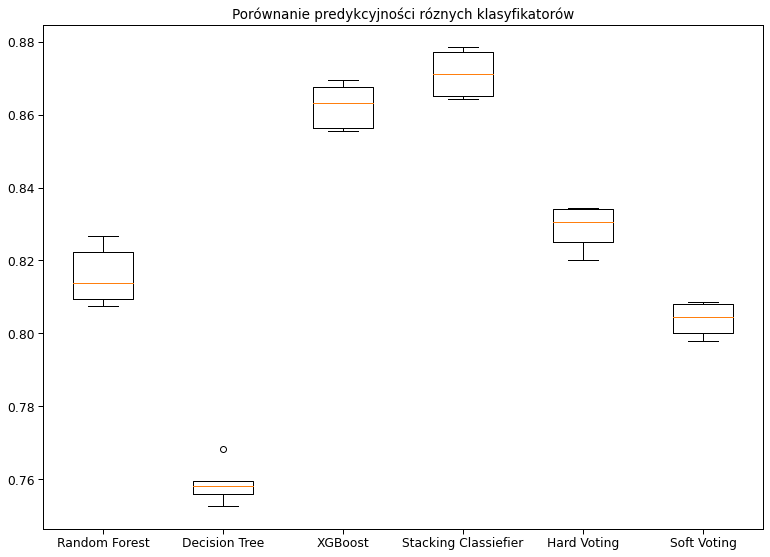

In [76]:
scores_all = [scores_rfc, scores_dtc, scores_xgbc, scores_stacking_clf, scores_voting_hard_clf, scores_voting_soft_clf]
fig = plt.figure(figsize =(10, 7))

ax = fig.add_axes([0, 0, 1, 1])

bp = ax.boxplot(scores_all)
ax.set_xticklabels(['Random Forest', 'Decision Tree',
                    'XGBoost', 'Stacking Classiefier',
                   'Hard Voting', 'Soft Voting'])

plt.title("Porównanie predykcyjności róznych klasyfikatorów")

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
plt.savefig('./Models/All_classifiers_cv_score_boxplot.png', dpi=300, bbox_inches='tight')

plt.show()

In [68]:
model_dtc3 = pickle.load(open('./Models/bin/DecisionTree_Model.sav', 'rb'))
model_rfc3 = pickle.load(open('./Models/bin/RandomForest_Model.sav', 'rb'))
stacking_clf = pickle.load(open('./Models/bin/StackingClassifier_Model.sav', 'rb'))
voting_hard_clf = pickle.load(open('./Models/bin/VotingHard_Model.sav', 'rb'))
voting_soft_clf = pickle.load(open('./Models/bin/VotingSoft_Model.sav', 'rb'))
xgb_clf4 = pickle.load(open('./Models/bin/XGBoost_Model.sav', 'rb'))

In [69]:
def preprocesing_test_set(chess_df):
    my_dict = {'draw': -1, 'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6,
        'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10, 'eleven': 11, 'twelve': 12, 'thirteen': 13, 
        'fourteen': 14, 'fifteen': 15, 'sixteen': 16}

    for key in my_dict.keys():
        chess_df.loc[chess_df["result"] == key, "result"] = my_dict[key] + 1

    chess_df['result'] = chess_df['result'].astype('int')

    le = LabelEncoder()
    integer_encoded = le.fit_transform(chess_df["black_king_file"])
    chess_df["black_king_file"] = integer_encoded + 1

    le = LabelEncoder()
    integer_encoded = le.fit_transform(chess_df["white_rook_file"])
    chess_df["white_rook_file"] = integer_encoded + 1

    le = LabelEncoder()
    integer_encoded = le.fit_transform(chess_df["white_king_file"])
    chess_df["white_king_file"] = integer_encoded + 1

    chess_df["kings_distance_rank"] = abs((chess_df["black_king_rank"]) - (chess_df["white_king_rank"]))
    chess_df["kings_distance_file"] = abs((chess_df["black_king_file"]) - (chess_df["white_king_file"]))
    chess_df["kings_distance_sum"] = (chess_df["kings_distance_rank"]) + (chess_df["kings_distance_file"])
    chess_df["kings_distance_metric"] = np.maximum(chess_df["kings_distance_rank"], chess_df["kings_distance_file"])
    rank = "black_king_rank"
    file = "black_king_file"
    chess_df["black_king_top_left_corner_distance"] = np.maximum(abs(1 - chess_df[rank]),abs(8 - chess_df[file]))
    chess_df["black_king_top_right_corner_distance"] = np.maximum(abs(8 - chess_df[rank]),abs(8 - chess_df[file]))
    chess_df["black_king_bottom_left_corner_distance"] = np.maximum(abs(1 - chess_df[rank]),abs(1 - chess_df[file]))
    chess_df["black_king_bottom_right_corner_distance"] = np.maximum(abs(8 - chess_df[rank]),abs(1 - chess_df[file]))
    chess_df["black_king_nearest_corner_distance"] = np.minimum(np.minimum(chess_df["black_king_top_left_corner_distance"], chess_df["black_king_top_right_corner_distance"]), np.minimum(chess_df["black_king_bottom_left_corner_distance"], chess_df["black_king_bottom_right_corner_distance"]))

    chess_df["black_king_nearest_side_distance"] = np.minimum(np.minimum( abs(chess_df[rank] - 8), abs(chess_df[rank] - 1) ), np.minimum( abs(chess_df[file] - 8), abs(chess_df[file] - 1) ))


    col_names = list(chess_df.columns)
    col_names.pop(6) # remove result

    min_max_scaler = MinMaxScaler()

    for col in col_names:
        scaled_col = min_max_scaler.fit_transform(chess_df[col].values.reshape(-1, 1))
        chess_df[col] = scaled_col


    negative_corr_list = ['white_king_file', 'white_king_rank', 'white_rook_file',
                          'white_rook_rank', 'black_king_top_right_corner_distance',
                          'black_king_bottom_right_corner_distance']

    for col in negative_corr_list:
        chess_df[col] = chess_df[col]*(-1)
        
    return chess_df

In [70]:
data_test = pd.concat([X_test, y_test], axis = 1)
data_test = data_test.reset_index()
data_test = data_test.drop("index", axis=1)

In [71]:
data_test = preprocesing_test_set(data_test)

In [72]:
X_test2 = data_test.drop("result", axis=1)
y_test2 = data_test["result"]
y_test2 = y_test2.astype('int')

In [73]:
print('Decision Tree')
show_model_metrics(model_dtc3, X_test2, y_test2)
print('--------------------------------------------------------------')
print('')
print('Random Forest')
show_model_metrics(model_rfc3, X_test2, y_test2)
print('--------------------------------------------------------------')
print('')
print('XGBoost')
show_model_metrics(xgb_clf4, X_test2, y_test2)
print('--------------------------------------------------------------')
print('')
print('Stacking Classier')
show_model_metrics(stacking_clf, X_test2, y_test2)
print('--------------------------------------------------------------')
print('')
print('Hard Voting')
show_model_metrics(voting_hard_clf, X_test2, y_test2)
print('--------------------------------------------------------------')
print('')
print('Soft Voting')
show_model_metrics(voting_soft_clf, X_test2, y_test2)

Decision Tree
F1 score: [0.71388102 0.66666667 0.92682927 0.94444444 0.85714286 0.91803279
 0.84571429 0.76859504 0.71974522 0.80836237 0.75707899 0.79081016
 0.77777778 0.78547411 0.76481368 0.81907895 0.80434783 0.76363636]
F1 score micro: 0.7829650748396294
F1 score weighted: 0.7825871799477195
Precision score: [0.75149105 0.66666667 0.86363636 0.91071429 0.83333333 0.90322581
 0.85057471 0.76229508 0.69753086 0.8        0.76969697 0.77857143
 0.78993056 0.77556441 0.75330927 0.82359427 0.79665072 0.75903614]
Recall score: [0.67985612 0.66666667 1.         0.98076923 0.88235294 0.93333333
 0.84090909 0.775      0.74342105 0.81690141 0.74486804 0.8034398
 0.76599327 0.79564033 0.77667494 0.81461287 0.81219512 0.76829268]
RMSE Error: 9.83927298645759
--------------------------------------------------------------

Random Forest
F1 score: [0.8119349  0.75       0.97435897 0.96226415 0.86486486 0.8852459
 0.89142857 0.81578947 0.77133106 0.8409894  0.80601504 0.83600493
 0.83952703 0.825

---

### Wybrany model
Dwa modele, które okazały się najlepszymi to `XGBoost` oraz `StackingClassifier`, minimalnie lepszy był ten drugi, dlatego właśnie `StackingClassifier` jest ostatecznie wybranym przez nas modelem.

### StackingClassifier - dalsza ewaluacja

In [74]:
print('Stacking Classier')
show_model_metrics(stacking_clf, X_test2, y_test2)

Stacking Classier
F1 score: [0.994614   1.         1.         0.99029126 0.91428571 0.96774194
 0.87150838 0.86440678 0.81605351 0.87543253 0.84802432 0.86773795
 0.86694561 0.869326   0.87980476 0.90266449 0.8923821  0.87581699]
F1 score micro: 0.8900570206699929
F1 score weighted: 0.8898995738808527
Precision score: [0.99283154 1.         1.         1.         0.88888889 0.9375
 0.85714286 0.87931034 0.82993197 0.86054422 0.88012618 0.87313433
 0.86189684 0.87777778 0.86554622 0.90021692 0.88489209 0.94366197]
Recall score: [0.99640288 1.         1.         0.98076923 0.94117647 1.
 0.88636364 0.85       0.80263158 0.89084507 0.81818182 0.86240786
 0.87205387 0.86103542 0.89454094 0.90512541 0.9        0.81707317]
RMSE Error: 0.33642195295794725


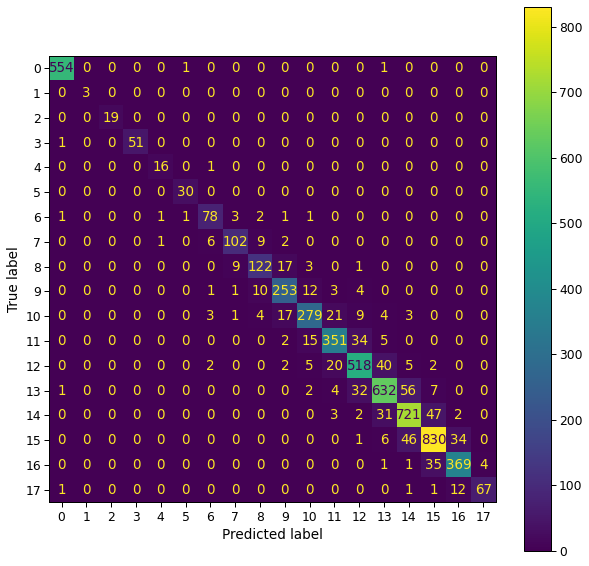

In [97]:
predictions = stacking_clf.predict(X_test2)
cm = confusion_matrix(y_test2, predictions, labels=stacking_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=stacking_clf.classes_)
disp.plot()
plt.show()

### StackingClassifier - interpretowalność

Ze względu na to, że `StackingClassifier` jest pewnym połączeniem innych modeli skupiliśmy się w tym miejscu na modelach składowych. Przez to, że `XGBoost` był z nich najlepszy, do niego przyłożyliśmy największa wagę. 

#### XGBoost

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

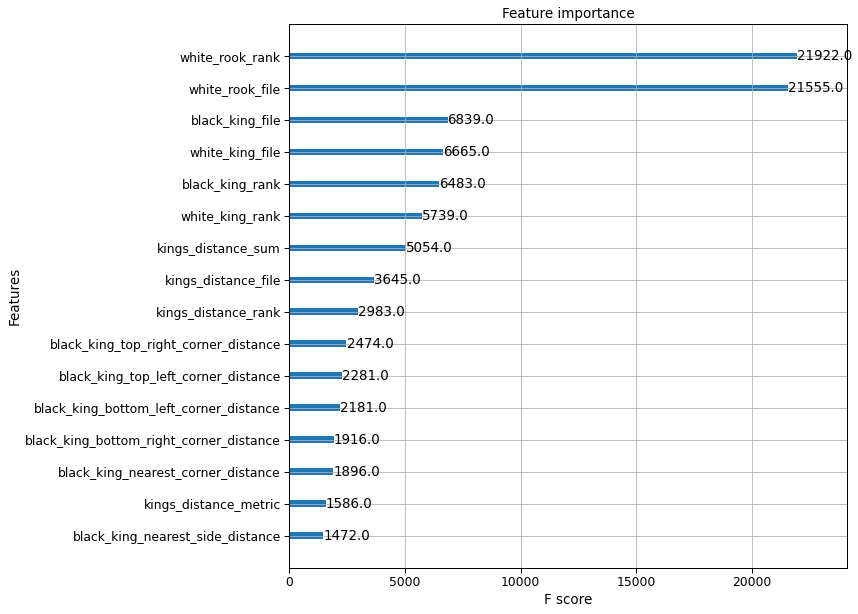

In [99]:
xgb.plot_importance(xgb_clf4)

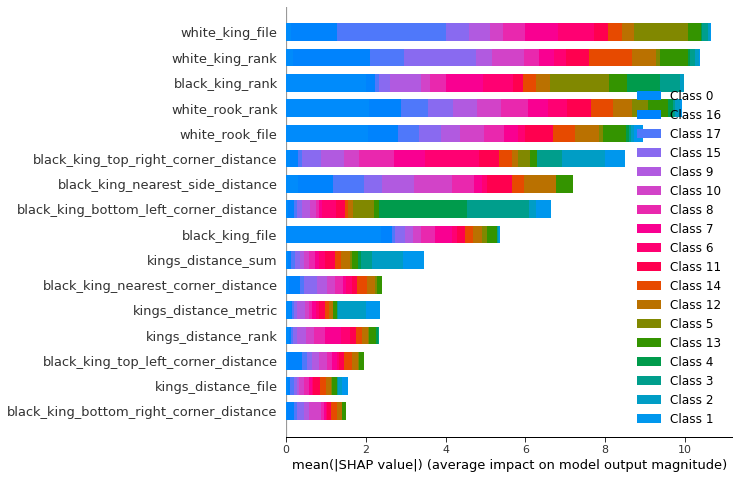

In [105]:
shap.summary_plot(shap_values, X.values, plot_type="bar",
                  feature_names = X.columns)

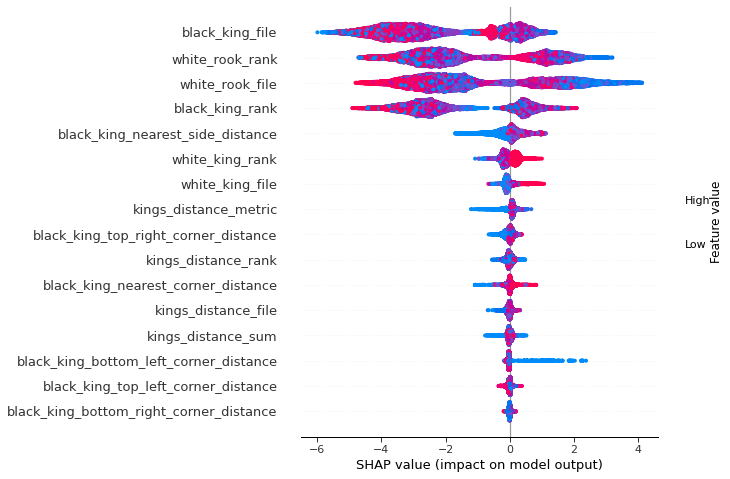

In [107]:
shap.summary_plot(shap_values[0], X.values, feature_names = X.columns)

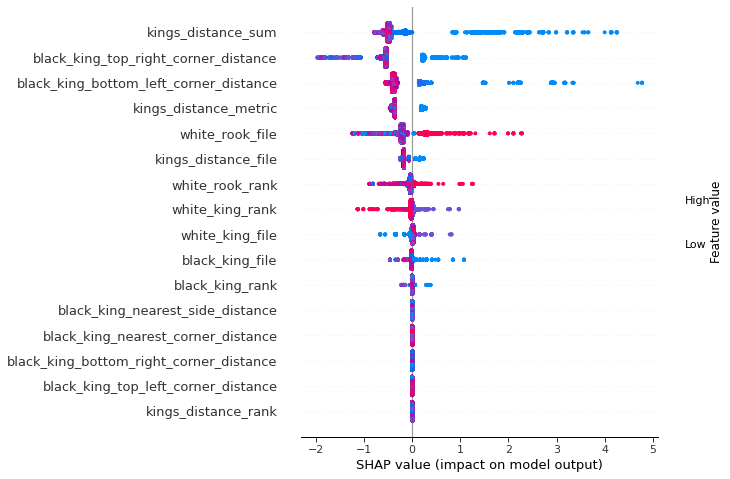

In [106]:
shap.summary_plot(shap_values[1], X.values, feature_names = X.columns)

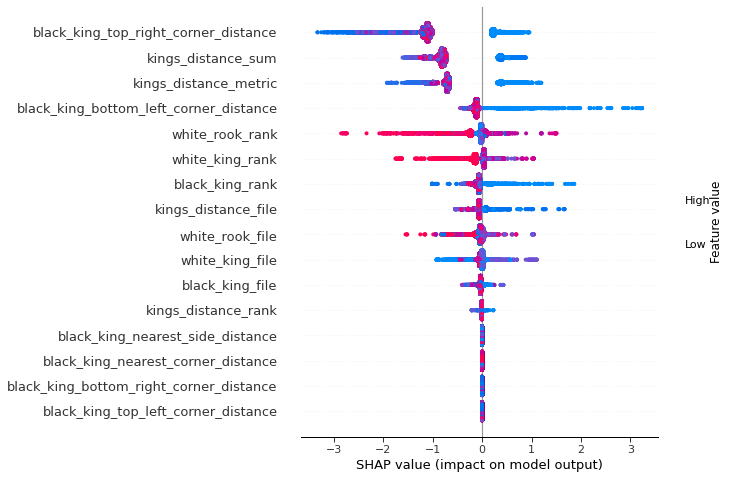

In [113]:
shap.summary_plot(shap_values[2], X.values, feature_names = X.columns)

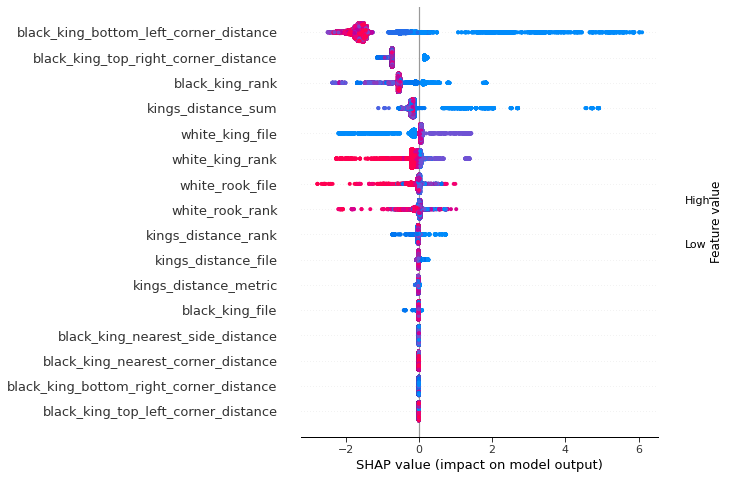

In [114]:
shap.summary_plot(shap_values[3], X.values, feature_names = X.columns)

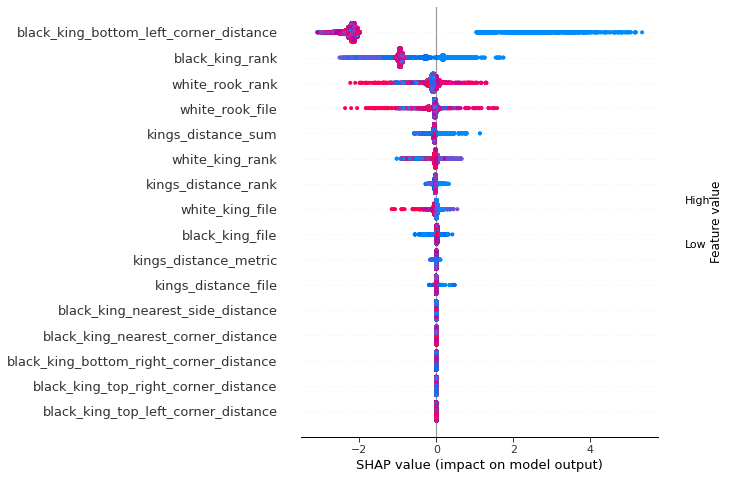

In [115]:
shap.summary_plot(shap_values[4], X.values, feature_names = X.columns)

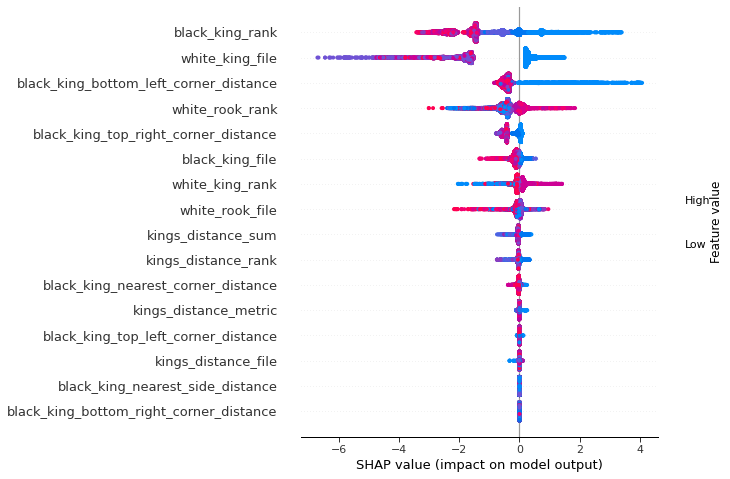

In [116]:
shap.summary_plot(shap_values[5], X.values, feature_names = X.columns)

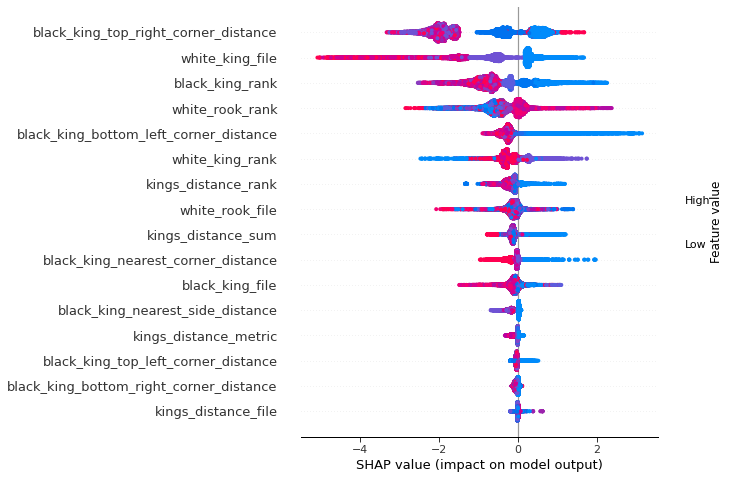

In [112]:
shap.summary_plot(shap_values[6], X.values, feature_names = X.columns)

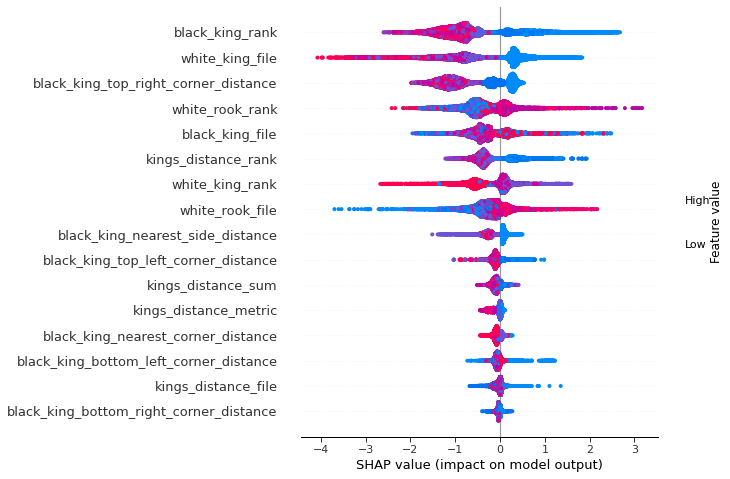

In [117]:
shap.summary_plot(shap_values[7], X.values, feature_names = X.columns)

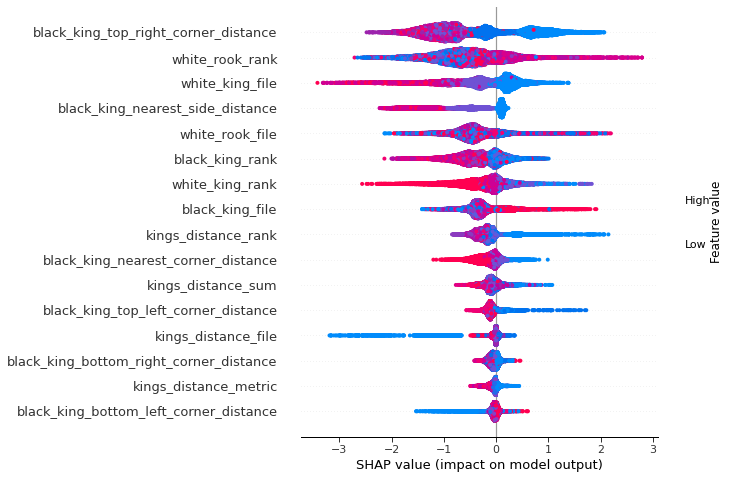

In [118]:
shap.summary_plot(shap_values[8], X.values, feature_names = X.columns)

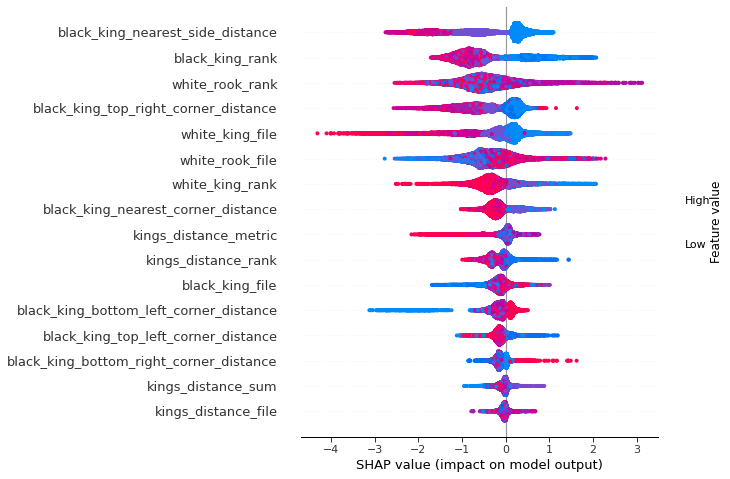

In [119]:
shap.summary_plot(shap_values[9], X.values, feature_names = X.columns)

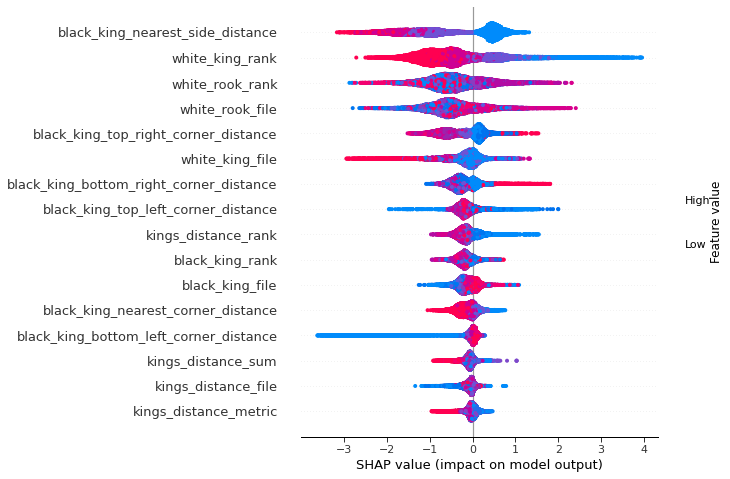

In [111]:
shap.summary_plot(shap_values[10], X.values, feature_names = X.columns)

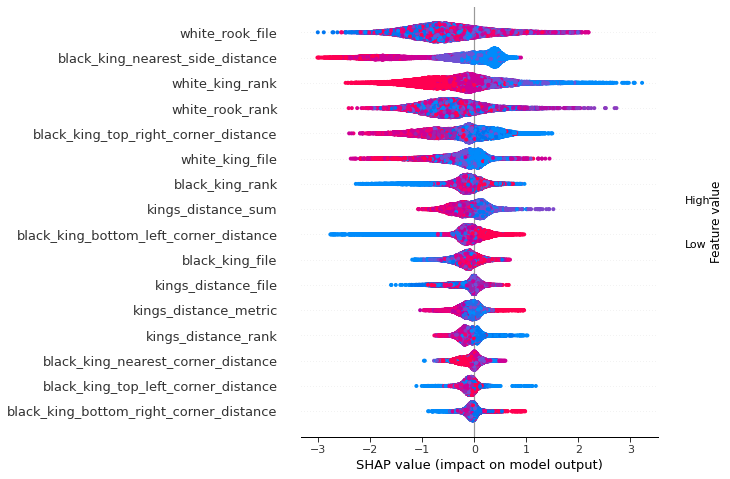

In [120]:
shap.summary_plot(shap_values[11], X.values, feature_names = X.columns)

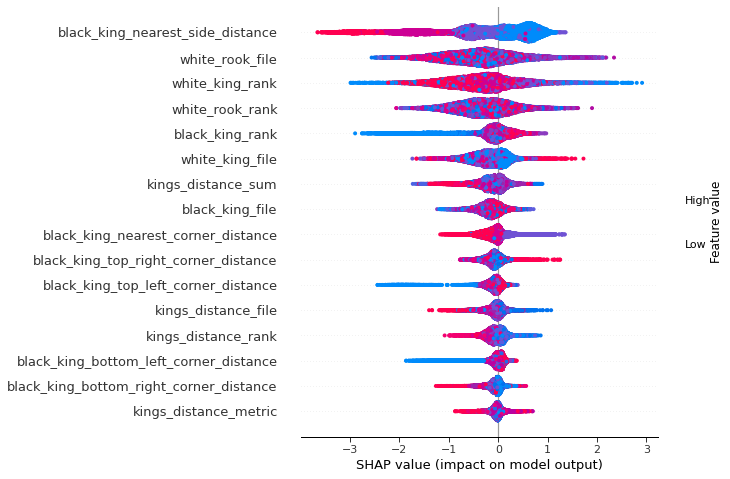

In [121]:
shap.summary_plot(shap_values[12], X.values, feature_names = X.columns)

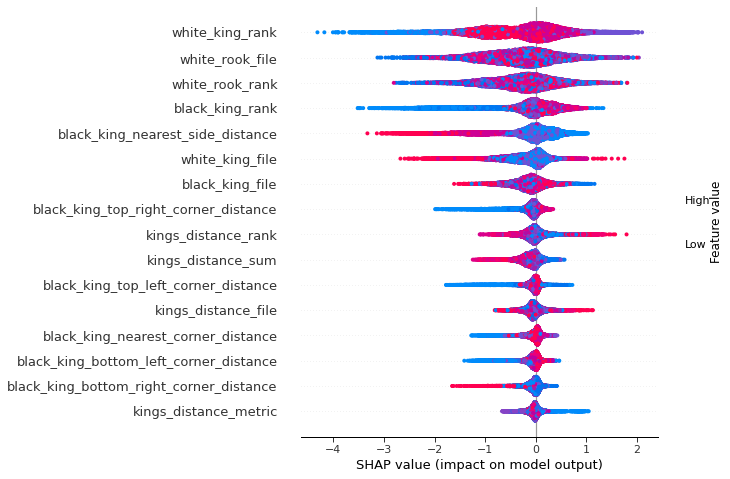

In [122]:
shap.summary_plot(shap_values[13], X.values, feature_names = X.columns)

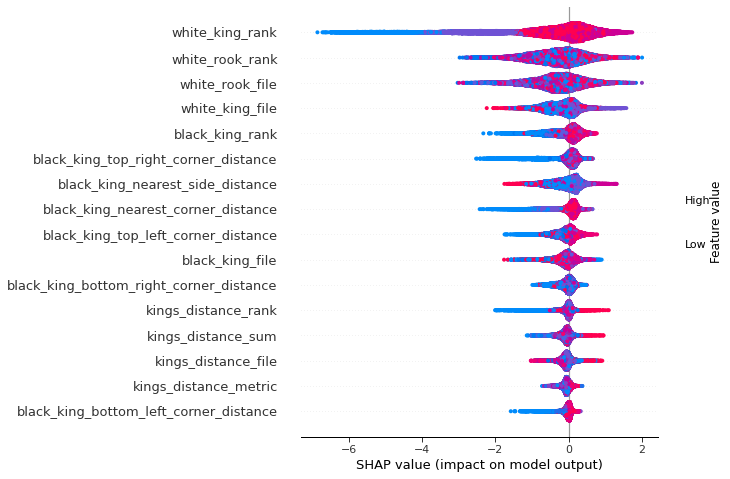

In [123]:
shap.summary_plot(shap_values[14], X.values, feature_names = X.columns)

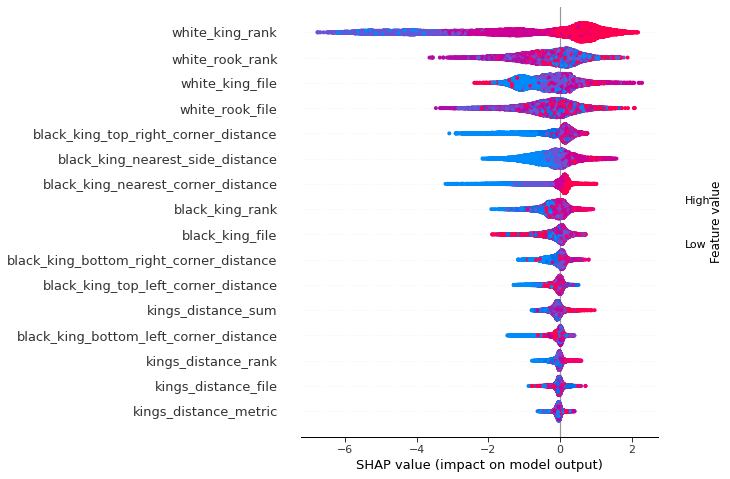

In [108]:
shap.summary_plot(shap_values[15], X.values, feature_names = X.columns)

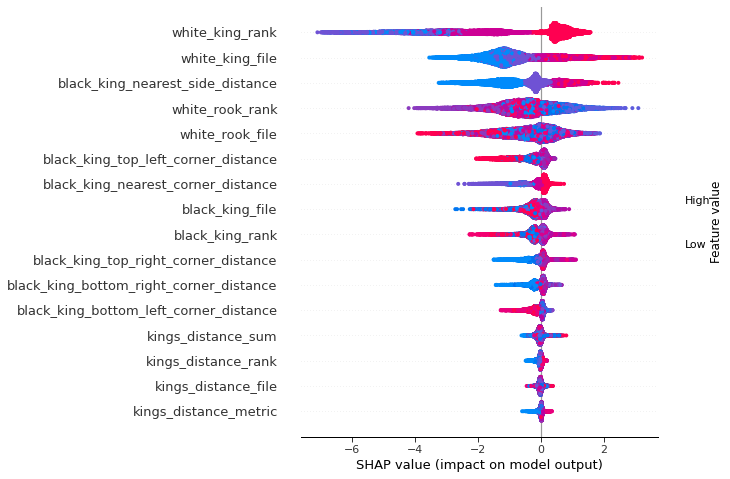

In [124]:
shap.summary_plot(shap_values[16], X.values, feature_names = X.columns)

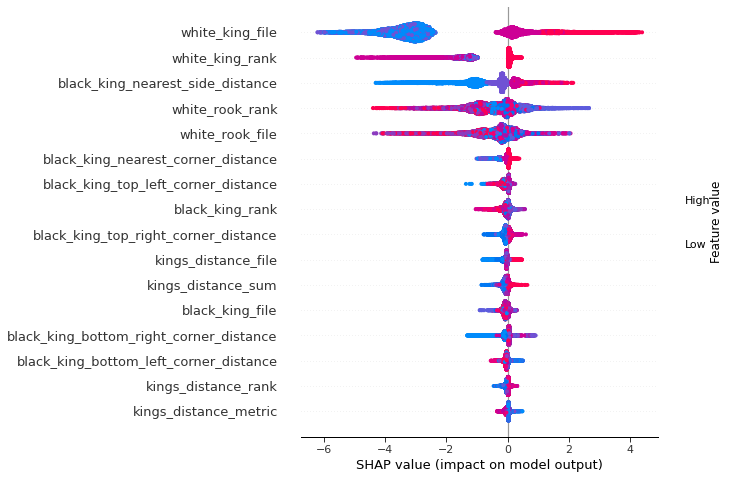

In [125]:
shap.summary_plot(shap_values[17], X.values, feature_names = X.columns)

Powyższe wykresy obrazują, że dla szybko skończonych partii (w małej ilości ruchów) model podejmuje decyzje zgodnie z naszą intuicją. Wraz ze wzrostem długości gier powoli coraz ciężej przychodzi nam analiza wykresów, analogiczne do tego, że niedoświadczonemu graczowi ciężko jest myśleć w szachach kilkanaście ruchów do przodu.

#### Random Forest

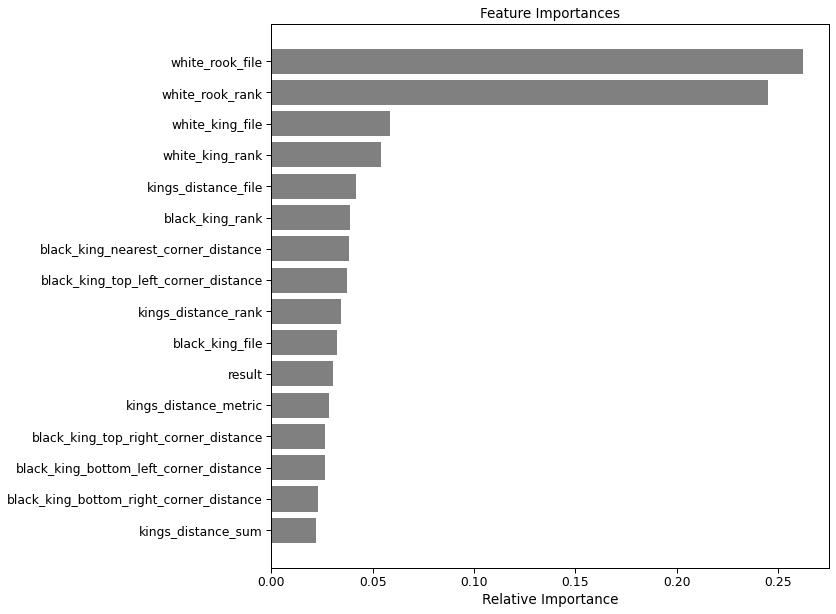

In [132]:
importances = model_rfc3.feature_importances_
indices = np.argsort(importances)
features = data_test.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='gray', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Decision Tree

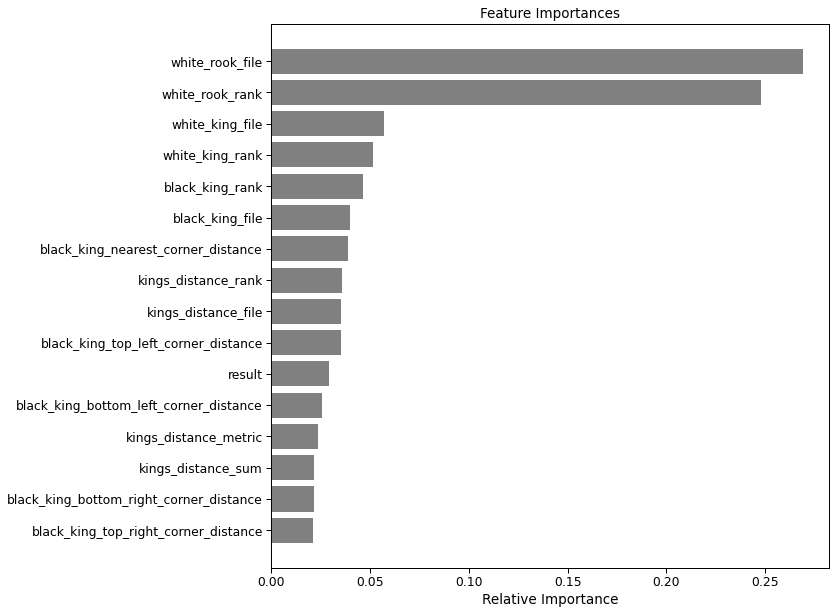

In [44]:
importances = model_dtc3.feature_importances_
indices = np.argsort(importances)
features = data_test.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='gray', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Podsumowanie
Wszystkie z warstwowych modeli wykorzystanych w finalnym modelu `StackingClassifier` posiadają podobne do siebie wykresy obrazujące ważność zmiennych. Stąd posiłkując się licznymi wykresami stworzonymi dla `XGBoosta` możemy stwierdzić, że finalny model jest interpretowalny i w głównej mierze zgodny z naszą intuicją.  
Wynikowy model osiągnął skuteczność, którą można zaokrąglić do około 90% a błąd RMSE wyniku wynosił ledwie ok. 0.34 .